"""

    GGPD: Deep Deterministic Policy Gradient [1] implementation in PyTorch [2].
    Minor changes were made to the backpropagation of the error for the critic and actor. 
    Also another type of noise was used in new task conditions.
    
    References
    ----------
    
    [1]   
    Lillicrap, T., Hunt, J. J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., Silver, D. & Wierstra, D. (2015). 
    Continuous control with deep reinforcement learning. International Conference on Learning Representations, 
    abs/1509.02971. https://arxiv.org/abs/1509.02971

    [2] https://github.com/ghliu/pytorch-ddpg
"""

In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern

from ddpg_fol.ddpg import DDPG
from ddpg_fol.util import *
from ddpg_fol.evaluator import Evaluator

from environment import Environment
from scipy.integrate import quad

In [4]:
from random import randint
def generate_fourier_random_function(domain_min, domain_max):
    """Generate random function using Fourier series and normalize"""
    n_terms = np.random.randint(2,6)
    L = domain_max - domain_min
    
    a0 = np.random.randn()
    a_coeffs = np.random.randn(n_terms)
    b_coeffs = np.random.randn(n_terms)
    
    def raw_function(x):
        result = a0/2
        for n in range(1, n_terms+1):
            result += np.array(a_coeffs[n-1]) * np.cos(2*n*np.pi*x/L)
            result += np.array(b_coeffs[n-1]) * np.sin(2*n*np.pi*x/L)
        return result
    
    def positive_function(x):
        return np.log(1 + np.exp(raw_function(x)))
    
    integral, _ = quad(positive_function, domain_min, domain_max)
    
    def normalized_function(x):
        res = []
        for i in x:
            res.append(positive_function(i) / integral)
        if len(res)==1:
            return res[0]
        else:
            return np.array(res)
    
    return normalized_function

# NN

In [56]:
train_size = 100
test_size = 20
np.random.seed(1)

num_models = train_size  + test_size  
num_samples = 6  

gp_models = []
prediction_functions = []
envs = []
observes = []

for _ in range(num_models):
    prediction_function = generate_fourier_random_function(-1, 1)
    prediction_functions.append(prediction_function)

    l_bounds = [-1,]
    u_bounds = [1,]
    env = Environment(X = np.array([[0]]*20),y = prediction_function(np.array([[0]]*20)),l_bounds = l_bounds,\
                      u_bounds = u_bounds, func = prediction_function, model = 'NN',\
                      model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1,'n_epoches':400},\
                      state_mode='predictions+last_points',N=20)
    observes.append(env.reset())
    envs.append(env)

In [4]:
# train_size = 100
# test_size = 20
# np.random.seed(1)

# def generate_training_data(num_samples):
#     X_train = np.linspace(-1, 1, num_samples).reshape(-1, 1)
#     y_train = np.random.random(num_samples) * 0.9 + 0.1
#     return X_train, y_train

# num_models = train_size  + test_size  
# num_samples = 6  

# gp_models = []
# prediction_functions = []
# envs = []
# observes = []

# for _ in range(num_models):
#     X_train, y_train = generate_training_data(num_samples)
    
#     kernel = RBF(length_scale=3)
    
#     gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
#     gp.fit(X_train, y_train)
    
#     gp_models.append(gp)
    
#     def prediction_function(x, model=gp):
#         x = np.array(x).reshape(-1, 1) 
#         y_pred, _ = model.predict(x, return_std=True)
#         if(y_pred.flatten().shape[0] == 1):
#             return y_pred.flatten()[0]
#         return y_pred.flatten()  
    
#     prediction_functions.append(prediction_function)

#     l_bounds = [-1,]
#     u_bounds = [1,]
#     env = Environment(X = np.array([[0]]*20),y = prediction_function(np.array([[0]]*20)),l_bounds = l_bounds,\
#                       u_bounds = u_bounds, func = prediction_function, model = 'NN',\
#                       model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1,'n_epoches':400},\
#                       state_mode='predictions+last_points',N=20)
#     observes.append(env.reset())
#     envs.append(env)

In [6]:
class Arg:
    def __init__(self,):
        self.mode = 'train'
        self.hidden1 = 16
        self.hidden2 = 16
        self.rate =0.0007
        self.prate =0.0007
        self.warmup =200
        self.discount=0.9
        self.bsize=64
        self.rmsize=100000
        self.window_length=1
        self.tau = 0.1
        self.validate_episodes=5
        self.max_episode_length=30
        self.validate_steps=500
        self.output='output_NN+'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=4000
        self.epsilon=4000
        self.seed = 1
        self.resume = 'default'
        
args = Arg()

np.random.seed(args.seed)

nb_states = envs[0].observation_space.shape[0]
nb_actions = envs[0].action_space.shape[0]

evaluate = Evaluator(test_size, args.validate_steps, args.output, max_episode_length=args.max_episode_length)
agent = DDPG(nb_states, nb_actions, args)
agent.epsilon = 0.5

train_functions_gauss = prediction_functions[:train_size]
test_functions_gauss = prediction_functions[train_size:]

train_envs = envs[:train_size]
test_envs = envs[train_size:]

  0%|                                                                                    | 0/100 [00:00<?, ?it/s]/Users/annaermakova/Desktop/rl/models/NN.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X = torch.tensor(X, dtype=torch.float32)
100%|███████████████████████████████████████████████████████████▉| 99.99999999999005/100 [54:07<00:00, 32.48s/it]


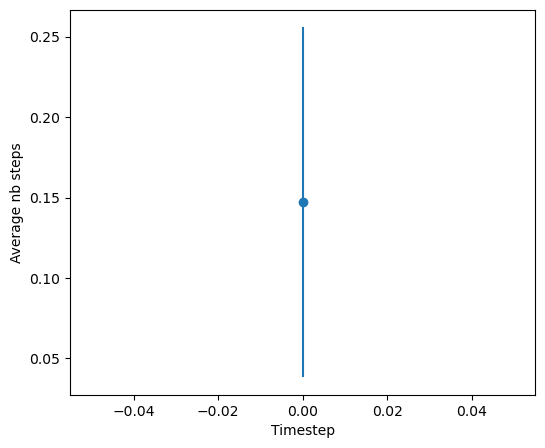

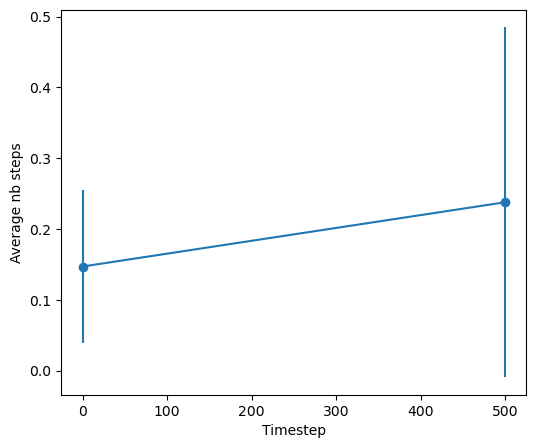

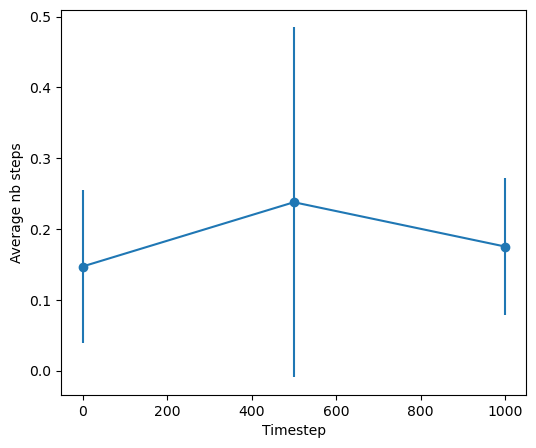

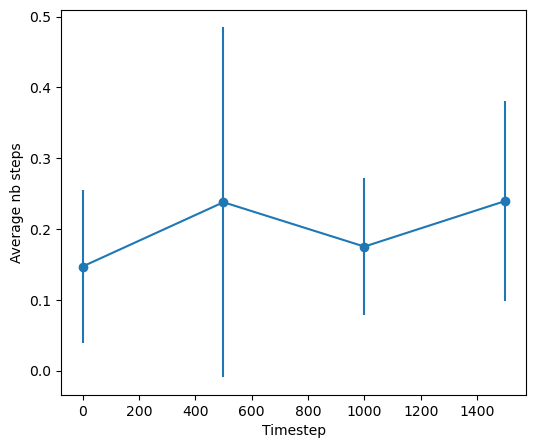

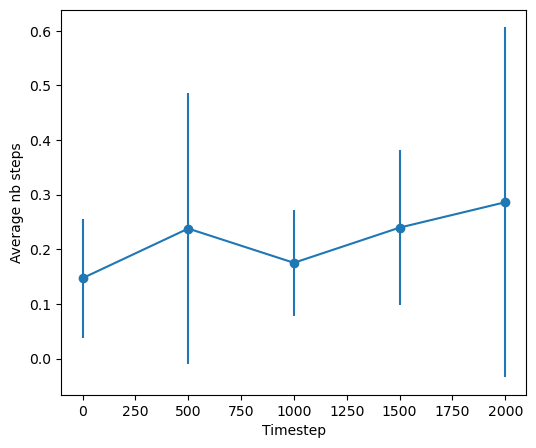

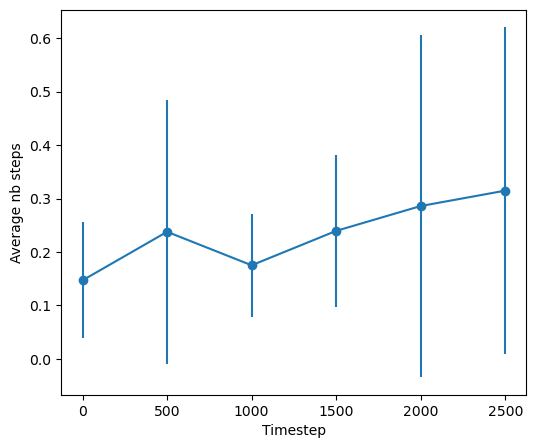

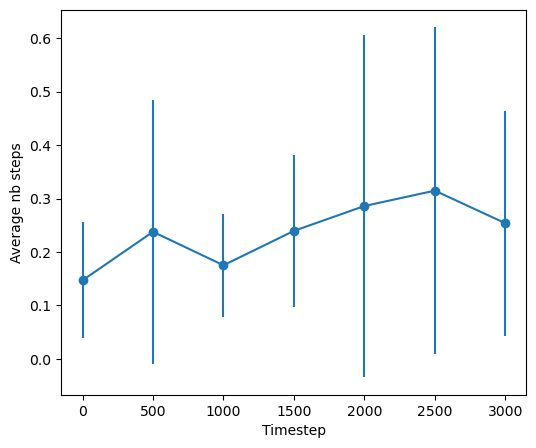

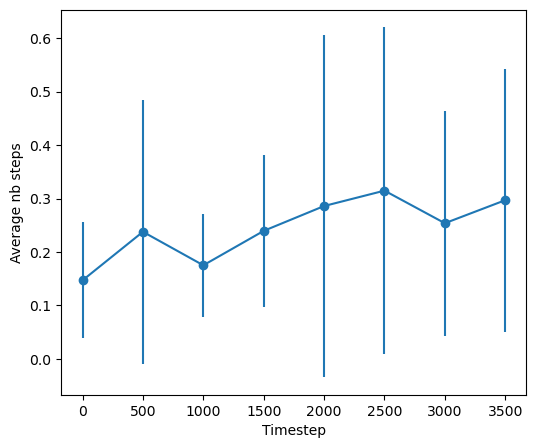

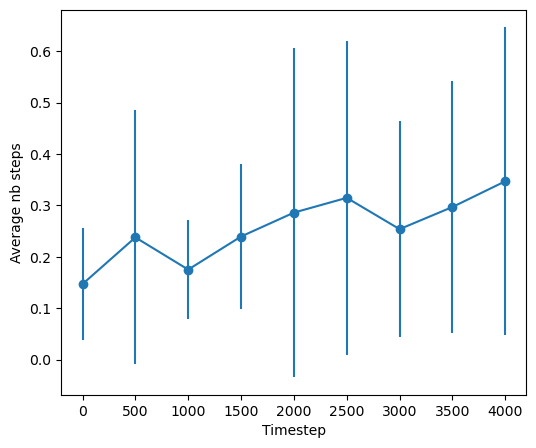

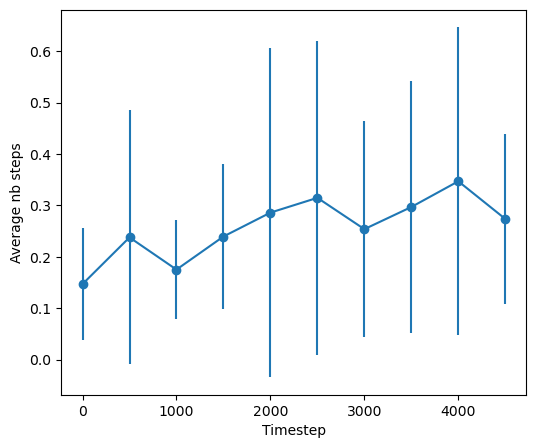

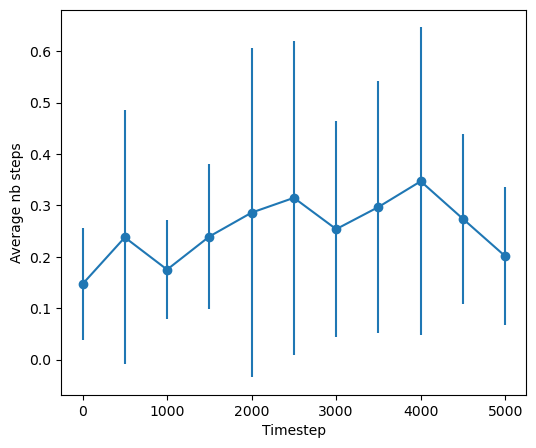

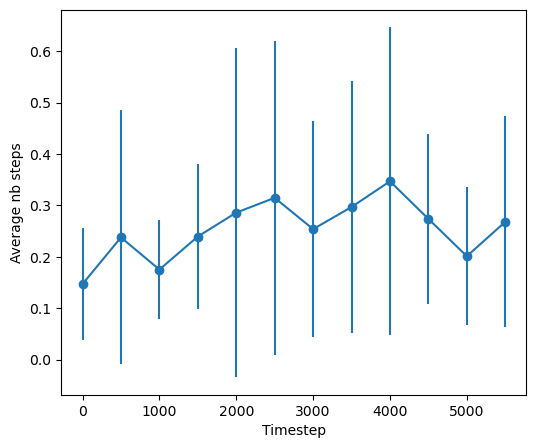

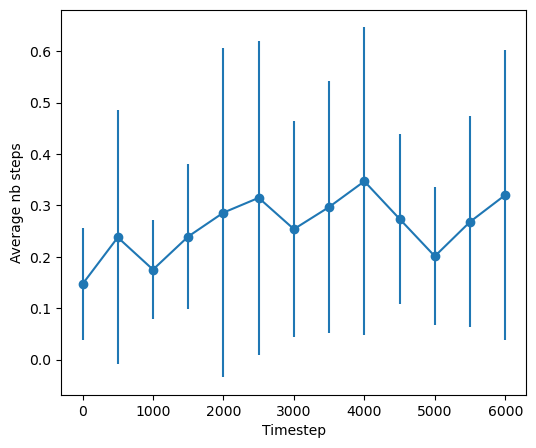

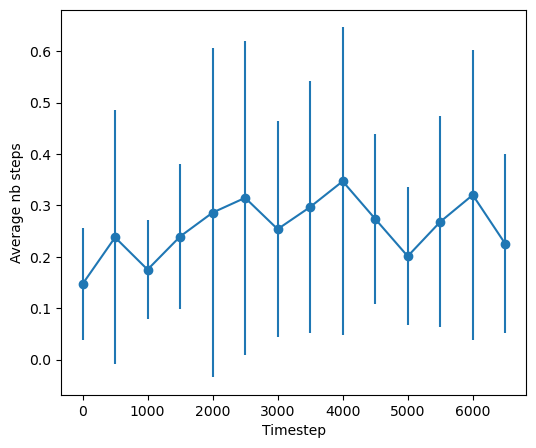

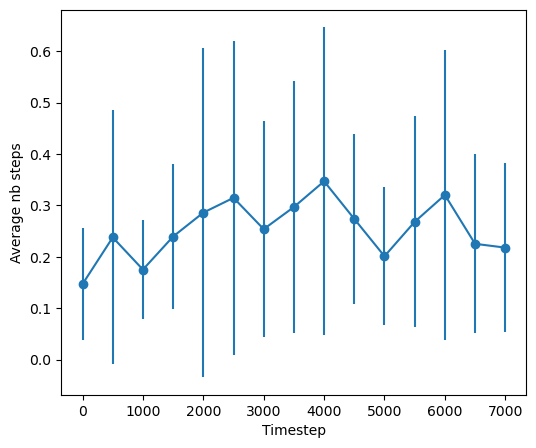

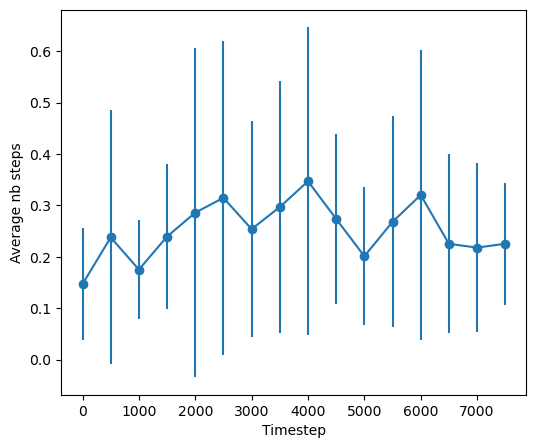

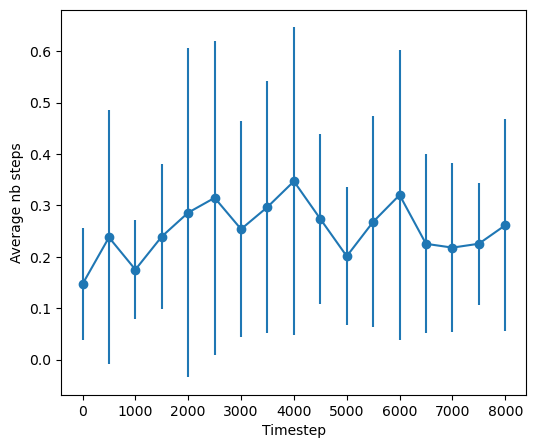

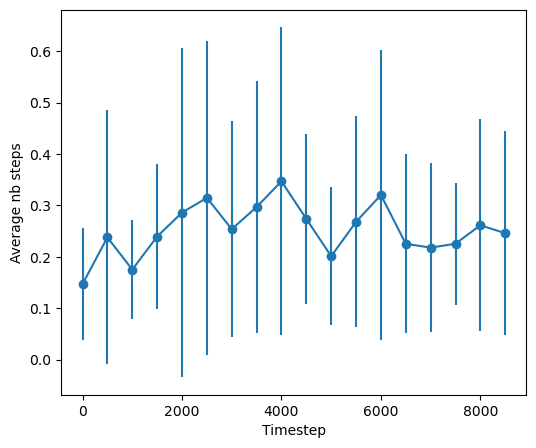

In [7]:
res = []

num_steps =  np.zeros(train_size)
agent.is_training = True
episode = episode_steps = 0
num_iterations = 9000
total_steps = 0
i=0
with tqdm(total=100) as pbar:
    while total_steps < num_iterations: 
        idx = i#random.sample(range(train_size), 1)[0]
        env = train_envs[idx]
        obs = observes[idx]
        num_step = num_steps[idx]

        if total_steps <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(obs)
            
        observation_new, reward, done, info = env.step(action)
        observes[idx] = deepcopy(observation_new)

        if reward<1:
            agent.observe(obs, action, reward, done)

        if episode > 5 and num_step % 10 == 0: 
            agent.update_policy()

        if total_steps>0 and total_steps % 500 == 0: 
            for _ in range(1000):
                agent.update_policy()
                
        if args.validate_steps > 0 and total_steps % args.validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(test_envs, policy, debug=False, visualize=False)
            #if debug: prYellow('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))

        num_steps[idx] = num_step + 1
        total_steps += 1
        pbar.update(100/num_iterations)
        if done or (num_steps[idx]>60): 
            res.append(reward)
            agent.save_model(args.output)
            #env.toy_Plot(np.linspace(-1,1,50))

            observes[idx] = deepcopy(env.reset())
            num_steps[idx] =0
            episode += 1
            i=(i+1)%train_size

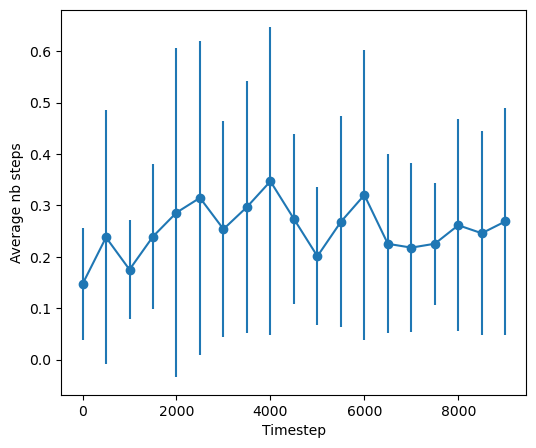

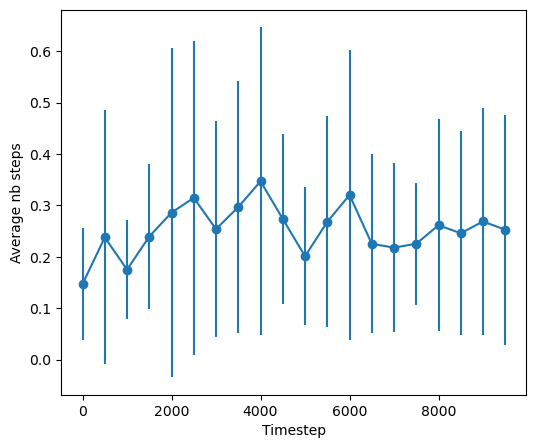

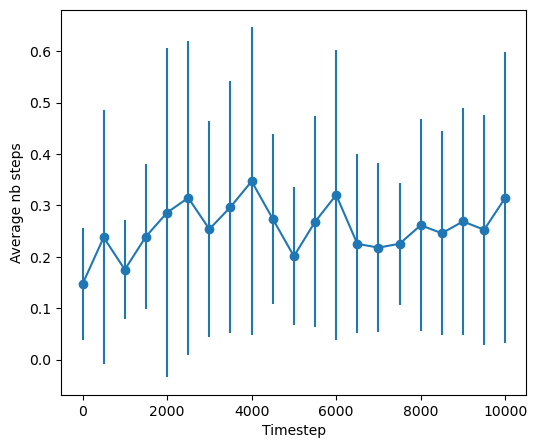

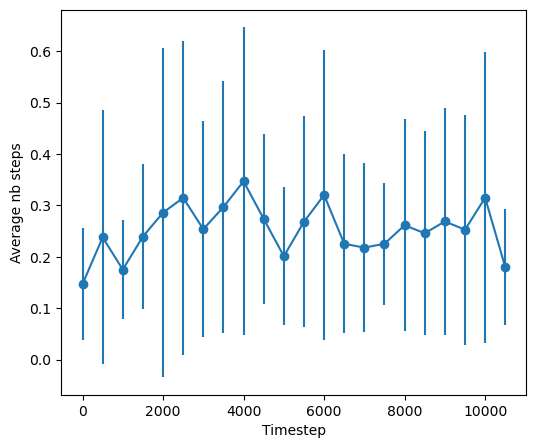

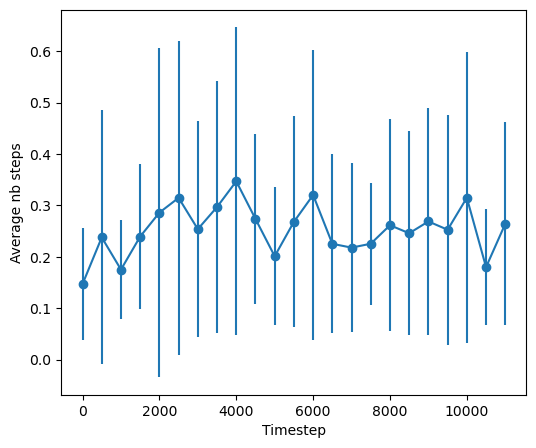

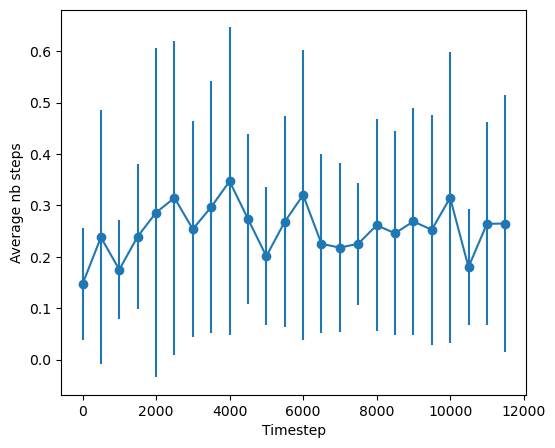

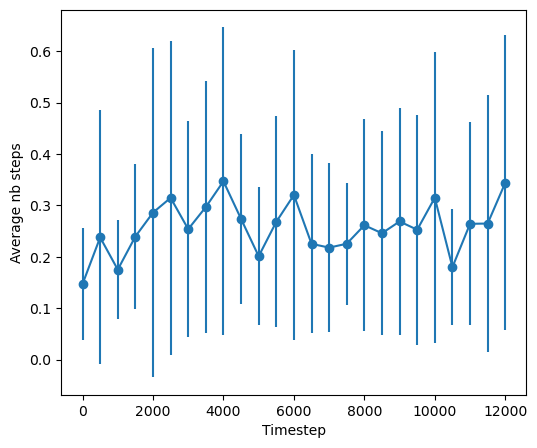

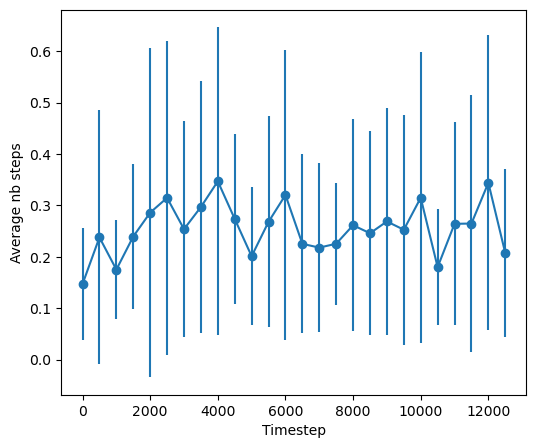

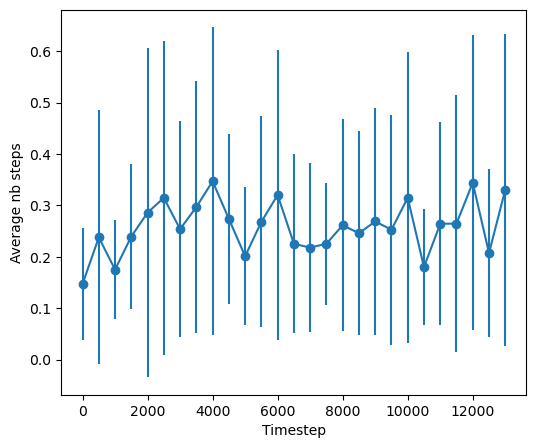

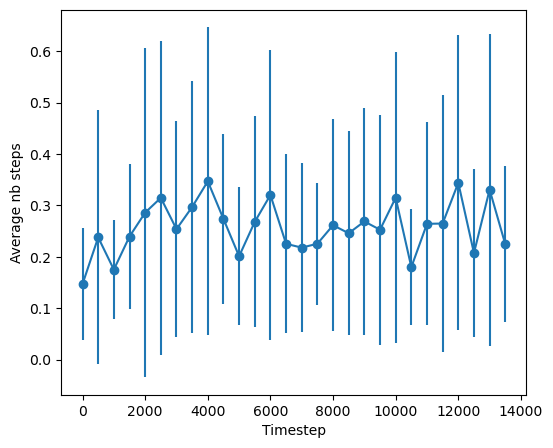

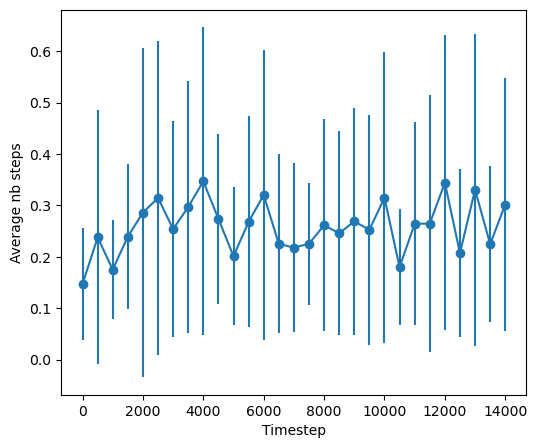

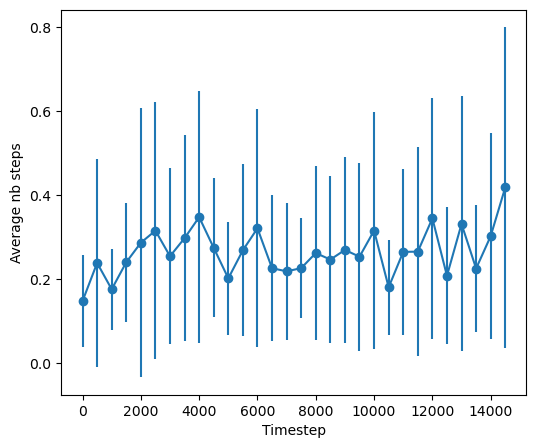

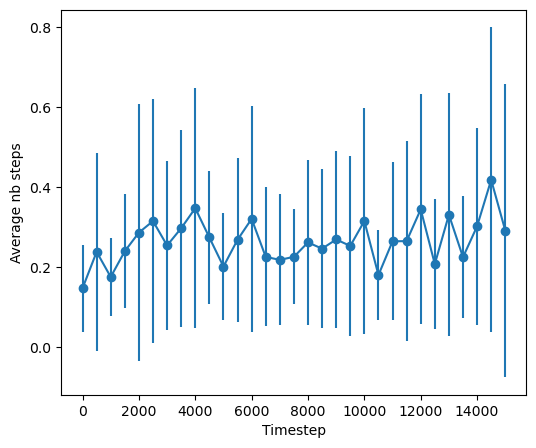

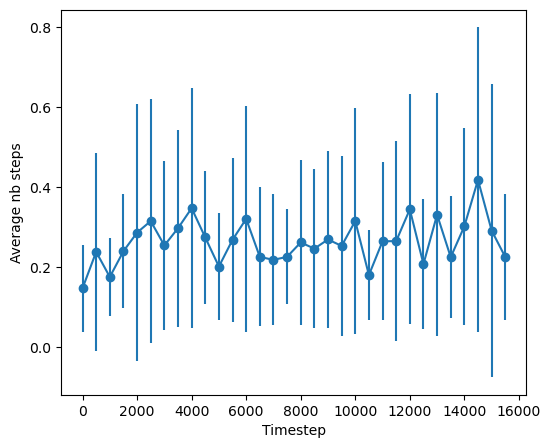

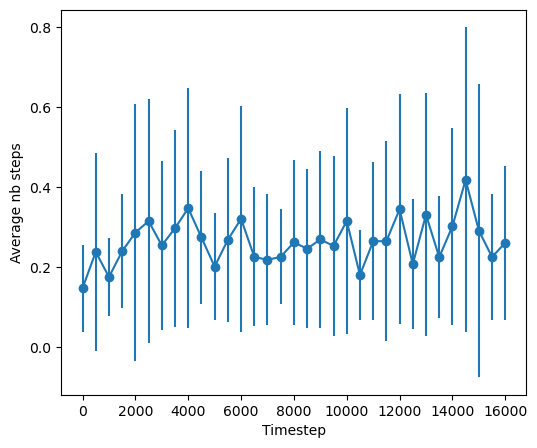

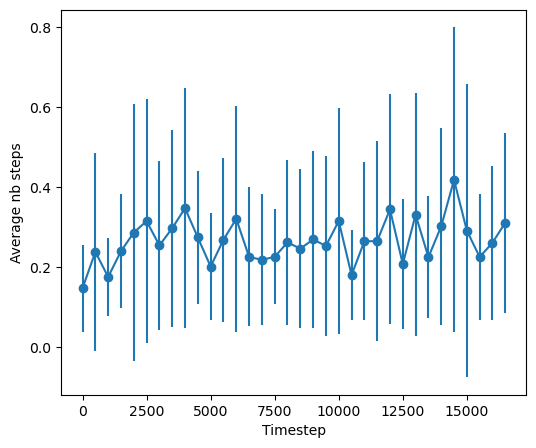

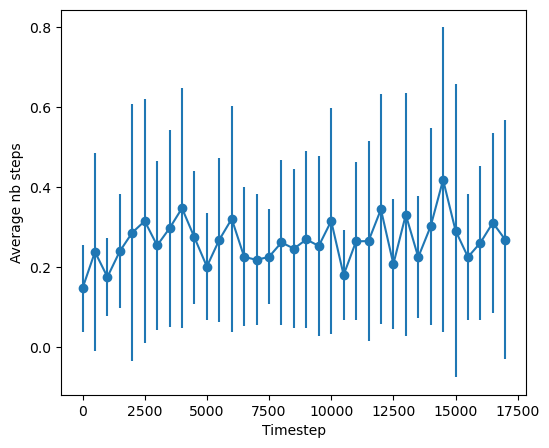

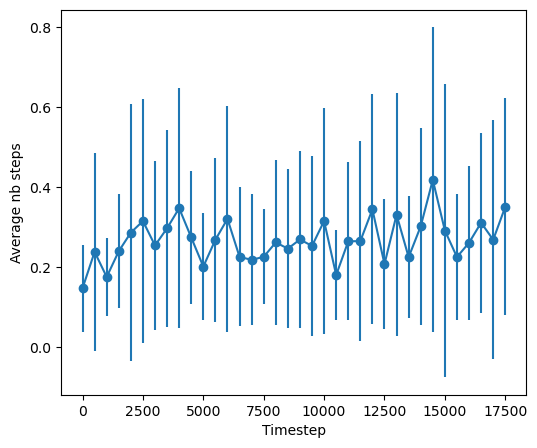

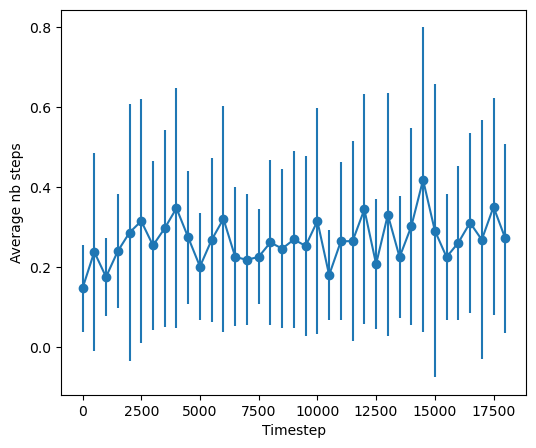

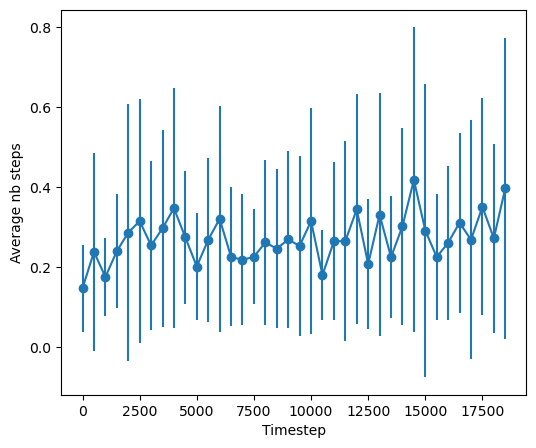

In [11]:
while total_steps < num_iterations+10000: 
        idx = i#random.sample(range(train_size), 1)[0]
        env = train_envs[idx]
        obs = observes[idx]
        num_step = num_steps[idx]

        if total_steps <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(obs)
            
        observation_new, reward, done, info = env.step(action)
        observes[idx] = deepcopy(observation_new)

        if reward<1:
            agent.observe(obs, action, reward, done)

        if episode > 5 and num_step % 10 == 0: 
            agent.update_policy()

        if total_steps>0 and total_steps % 500 == 0: 
            for _ in range(1000):
                agent.update_policy()
                
        if args.validate_steps > 0 and total_steps % args.validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(test_envs, policy, debug=False, visualize=False)
            #if debug: prYellow('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))

        num_steps[idx] = num_step + 1
        total_steps += 1
        pbar.update(100/num_iterations)
        if done or (num_steps[idx]>60): 
            res.append(reward)
            agent.save_model(args.output)
            #env.toy_Plot(np.linspace(-1,1,50))

            observes[idx] = deepcopy(env.reset())
            num_steps[idx] =0
            episode += 1
            i=(i+1)%train_size

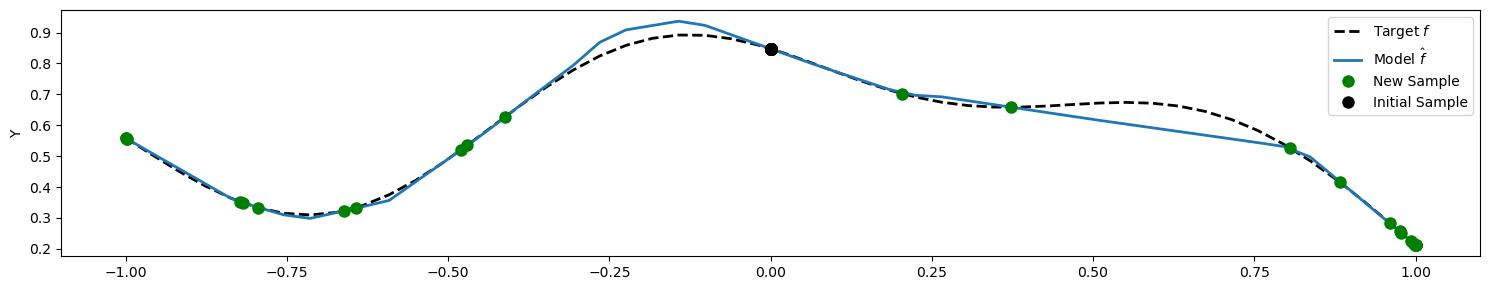

In [15]:
env = envs[8]
state = env.reset()
agent.is_training = False

done=False
while not done:
    action = agent.select_action(state)
    state, reward, done, info = env.step(action)
env.toy_Plot(np.linspace(-1,1,50))

# GP

In [26]:
train_size = 50
test_size = 20

num_models = train_size  + test_size  

prediction_functions = []
envs = []
observes = []

for _ in range(num_models):
    prediction_function = generate_fourier_random_function(-1, 1)

    l_bounds = [-1,]
    u_bounds = [1,]
    
    env = Environment(X = np.array([[0.]]*20),y = prediction_function(np.array([[0.]]*20)),l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = prediction_function, model = 'GP',model_param = {'d':1,'seed':1,'kernel':ConstantKernel(1.0) * Matern([1],nu=1.5),'n_restarts_optimizer':100},state_mode='predictions+last_points',N_state=20)
    
    prediction_functions.append(prediction_function)
    observes.append(env.reset())
    envs.append(env)

In [27]:
class Arg:
    def __init__(self,):
        self.mode = 'train'
        self.hidden1 = 32
        self.hidden2 = 32
        self.rate =0.0007
        self.prate =0.0007
        self.warmup =200
        self.discount=0.9
        self.bsize=64
        self.rmsize=100000
        self.window_length=1
        self.tau = 0.1
        self.validate_episodes=5
        self.max_episode_length=60
        self.validate_steps=500
        self.output='output_GP+'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=4000
        self.epsilon=10000
        self.seed = 1
        self.resume = 'default'
               
args = Arg()

np.random.seed(args.seed)

nb_states = envs[0].observation_space.shape[0]
nb_actions = envs[0].action_space.shape[0]

evaluate = Evaluator(test_size, args.validate_steps, args.output, max_episode_length=args.max_episode_length)
agent = DDPG(nb_states, nb_actions, args)
agent.epsilon = 0.5

train_functions_gauss = prediction_functions[:train_size]
test_functions_gauss = prediction_functions[train_size:]

train_envs = envs[:train_size]
test_envs = envs[train_size:]

 12%|██▎                 | 11.666666666666863/100 [1:40:09<12:38:18, 515.07s/it]


KeyboardInterrupt: 

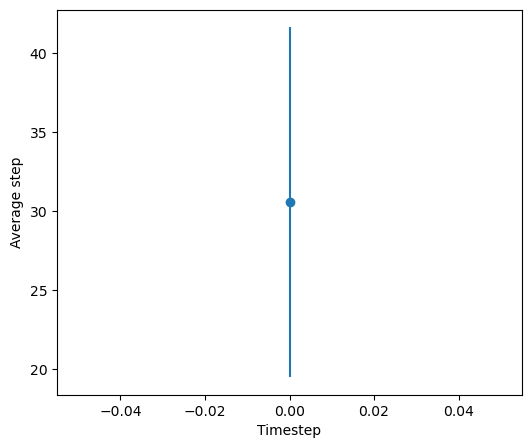

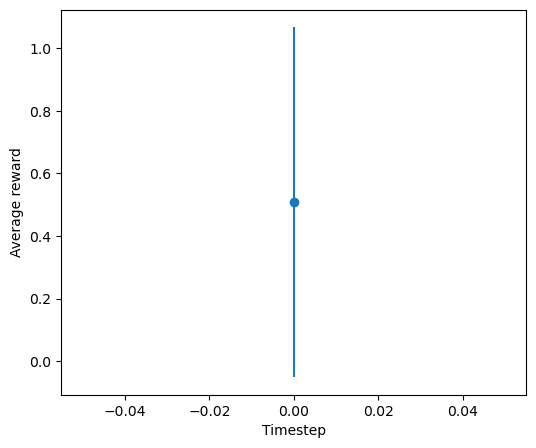

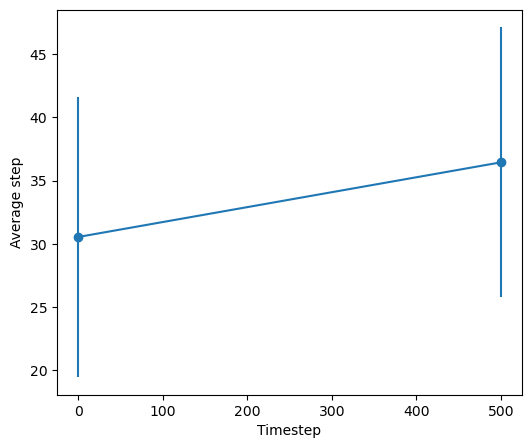

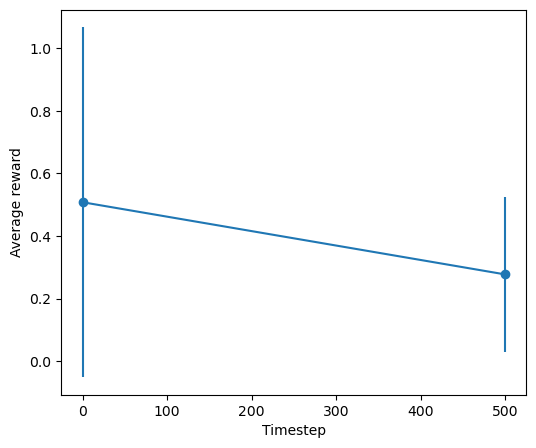

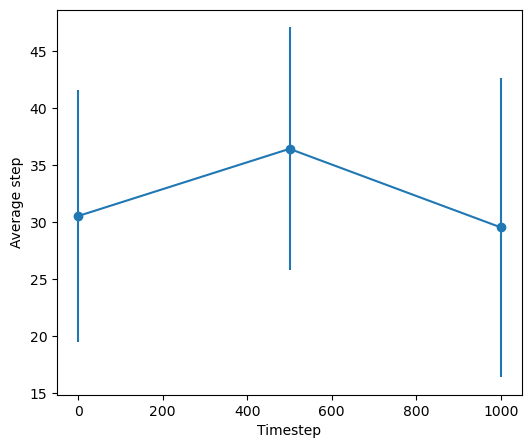

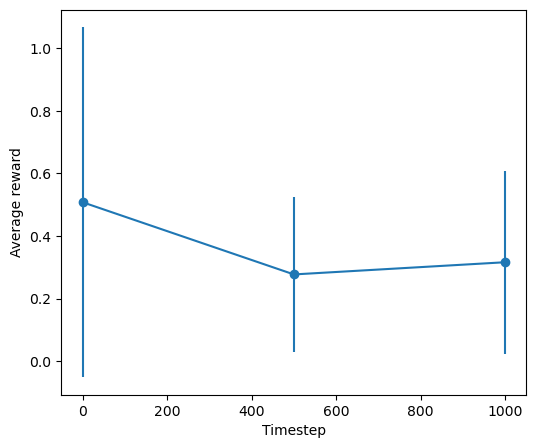

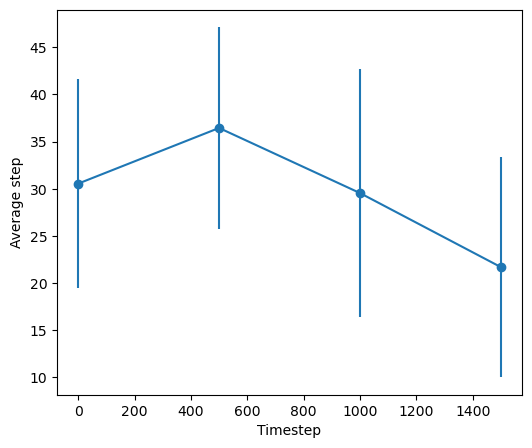

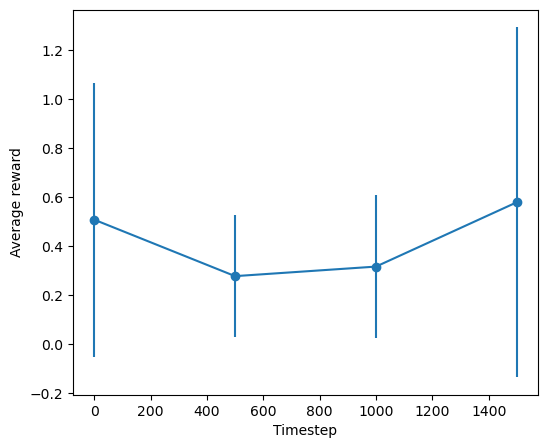

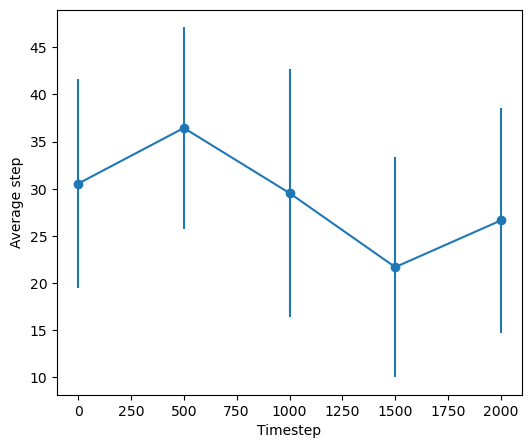

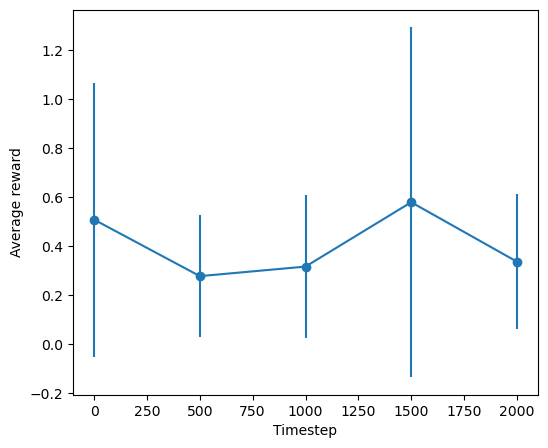

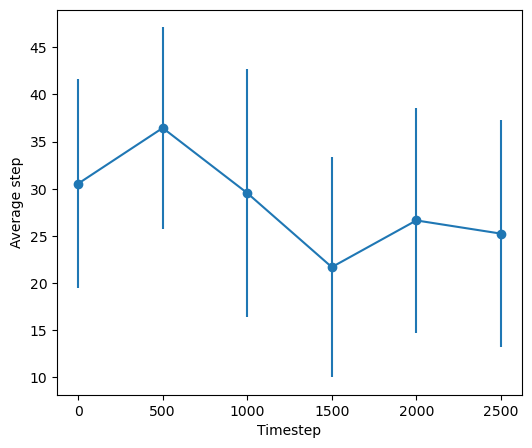

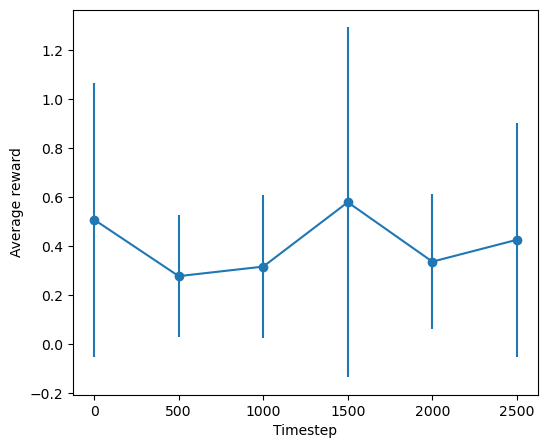

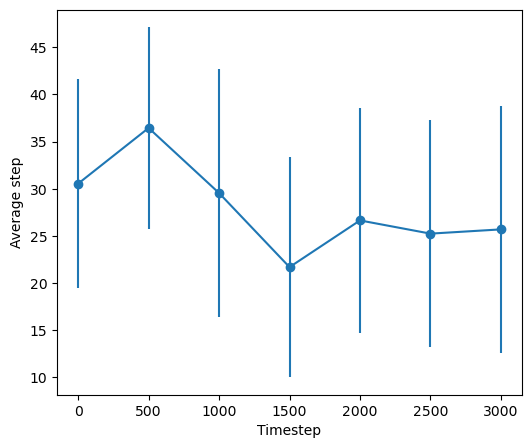

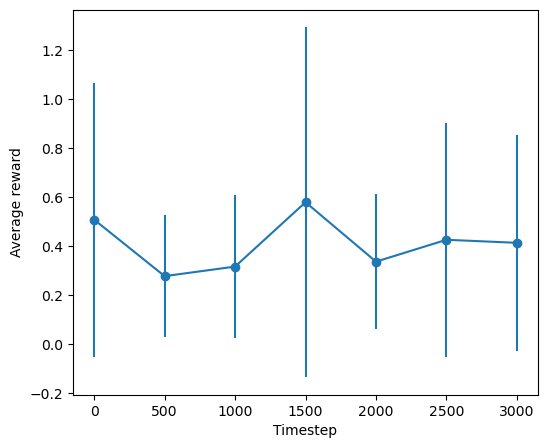

In [28]:
res = []

num_steps =  np.zeros(train_size)
agent.is_training = True
episode = episode_steps = 0
num_iterations = 30000
total_steps = 0
i=0
with tqdm(total=100) as pbar:
    while total_steps < num_iterations: 
        idx = i#random.sample(range(train_size), 1)[0]
        env = train_envs[idx]
        obs = observes[idx]
        num_step = num_steps[idx]

        if total_steps <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(obs)
        
    
        observation_new, reward, done, info = env.step(action)
        
        observes[idx] = deepcopy(observation_new)

        #if reward<1:
        agent.observe(obs, action, reward, done)

        # if episode > 5 and num_step % 10 == 0: 
        #     agent.update_policy()

        if total_steps>0 and total_steps % 500 == 0: 
            for _ in range(1000):
                agent.update_policy()
                
        if args.validate_steps > 0 and total_steps % args.validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward1,validate_reward2 = evaluate(test_envs, policy, debug=False, visualize=False,use_step=True)
          
        num_steps[idx] = num_step + 1
        total_steps += 1
        pbar.update(100/num_iterations)
        if done or (num_steps[idx]>60): 
            res.append(reward)
            agent.save_model(args.output)
            #env.toy_Plot(np.linspace(-1,1,50))

            observes[idx] = deepcopy(env.reset())
            num_steps[idx] =0
            episode += 1
            i=(i+1)%train_size

In [36]:
agent.depsilon = agent.epsilon/3000

 62%|████████████▉        | 61.709999999976354/100 [8:05:24<5:01:11, 471.96s/it]


KeyboardInterrupt: 

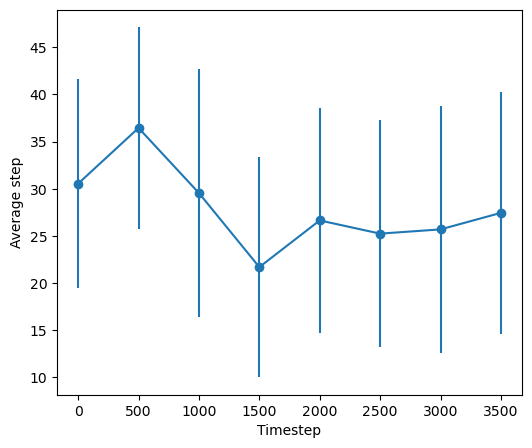

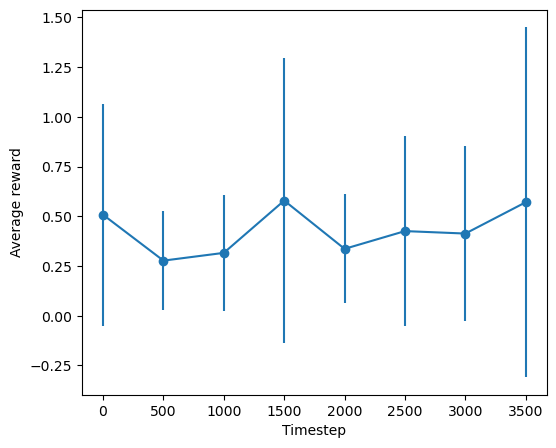

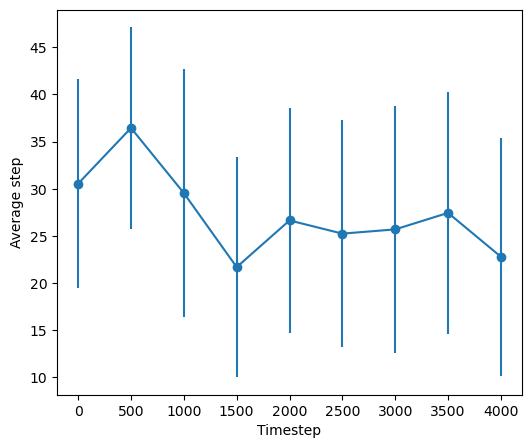

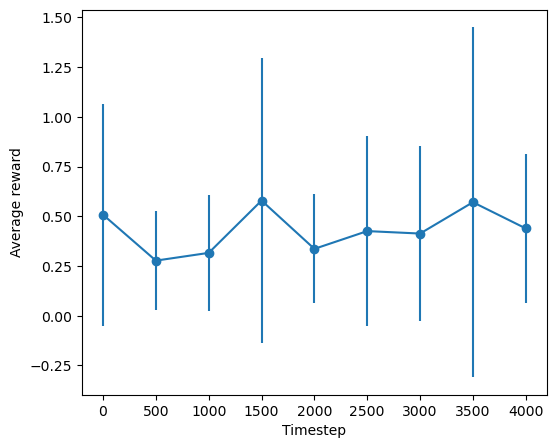

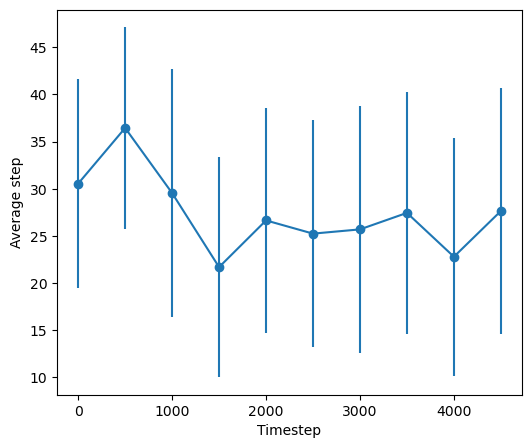

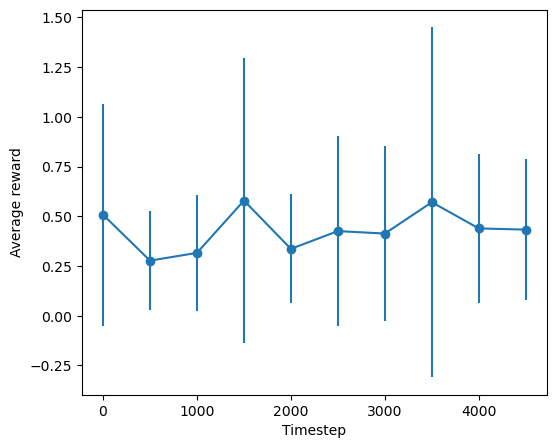

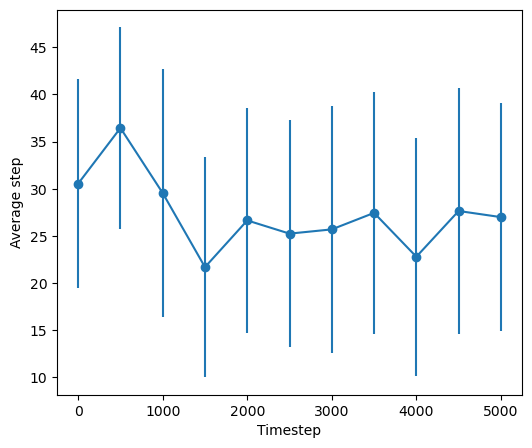

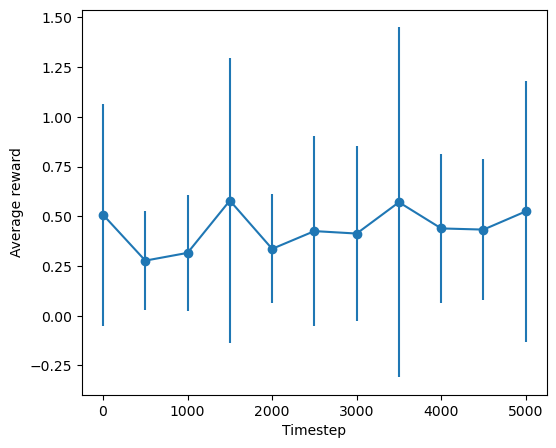

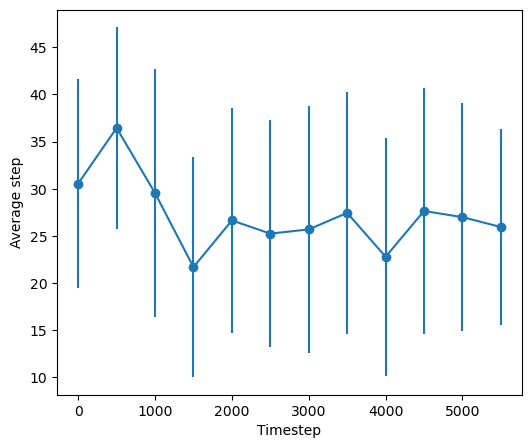

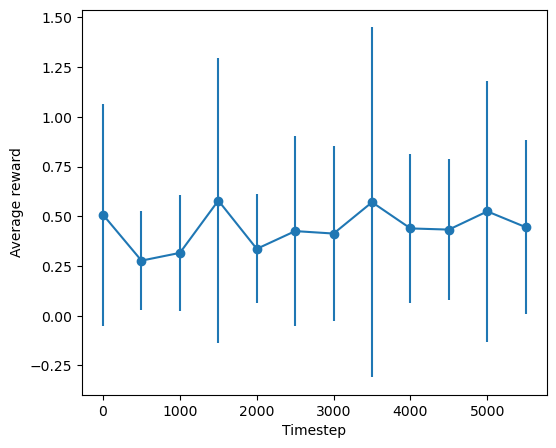

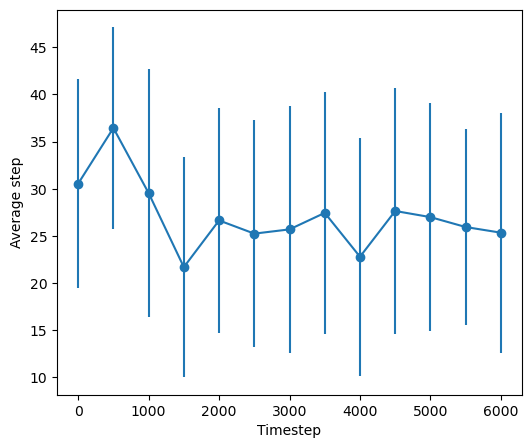

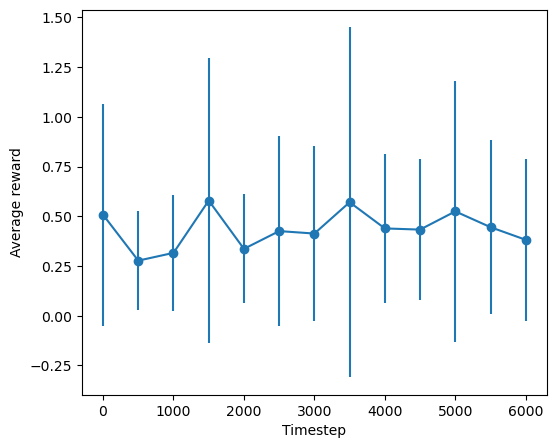

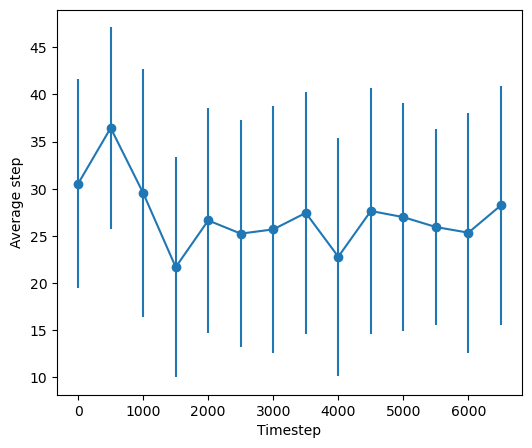

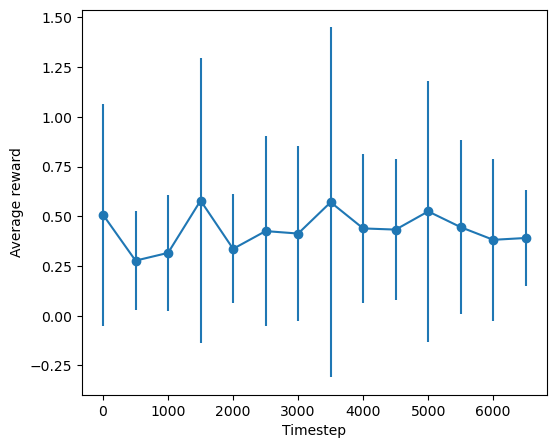

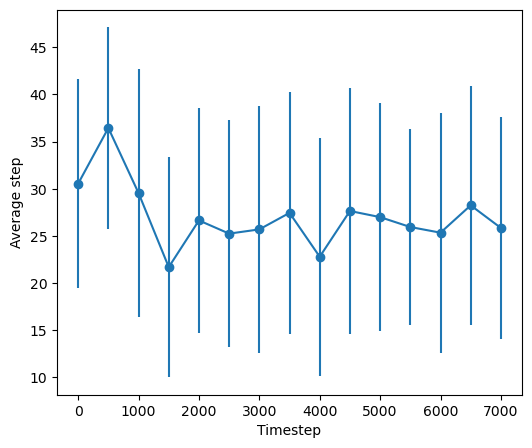

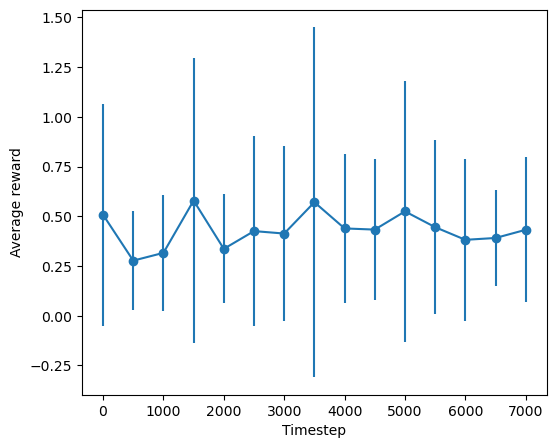

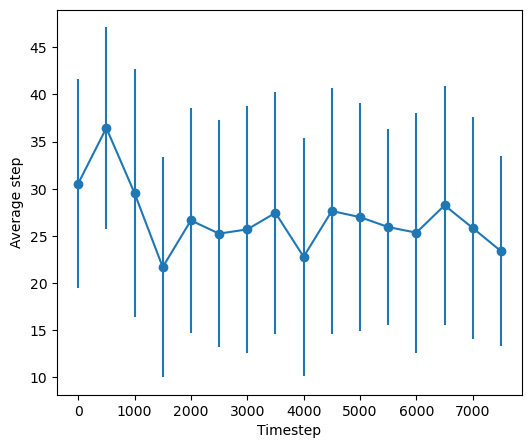

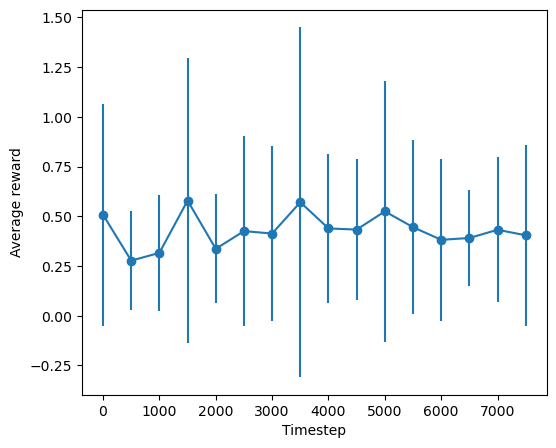

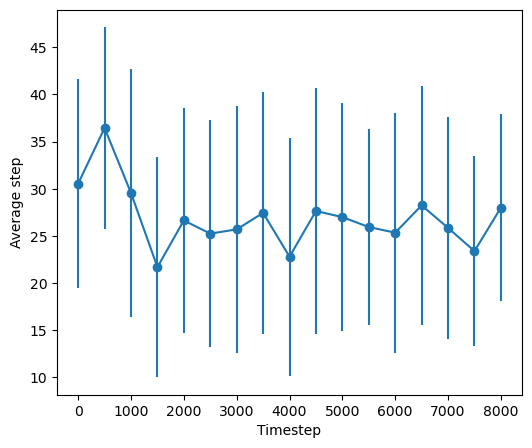

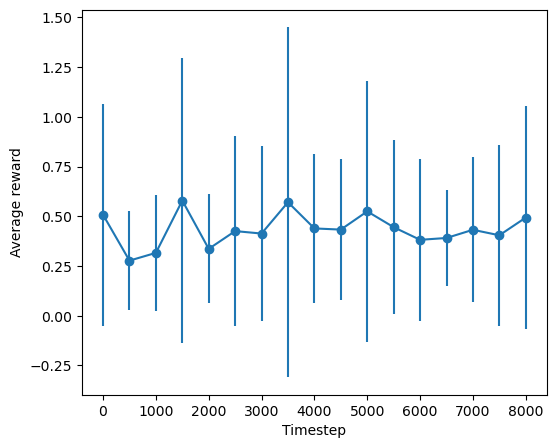

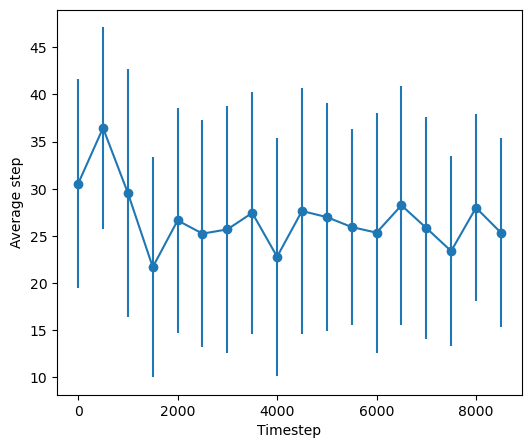

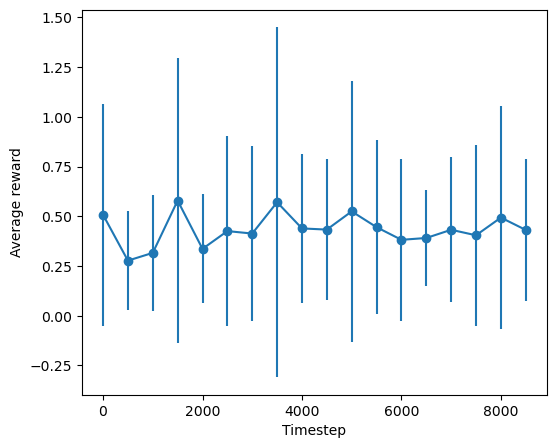

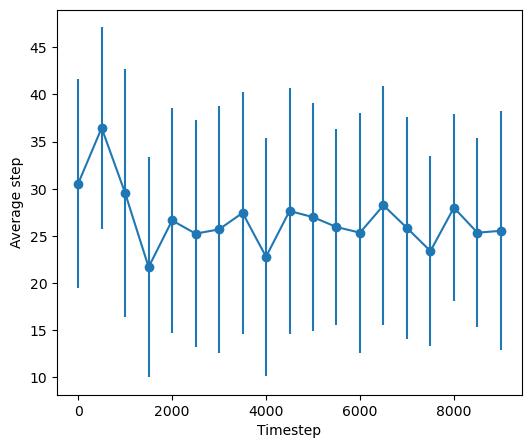

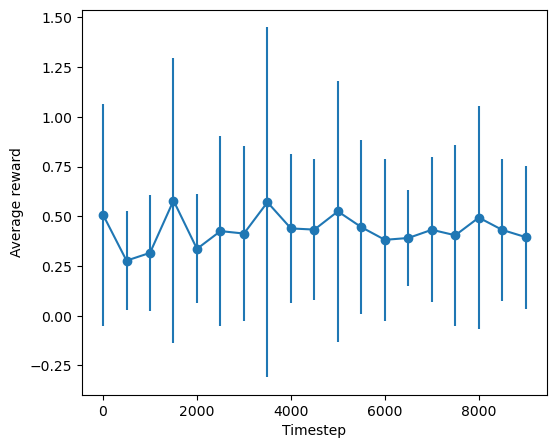

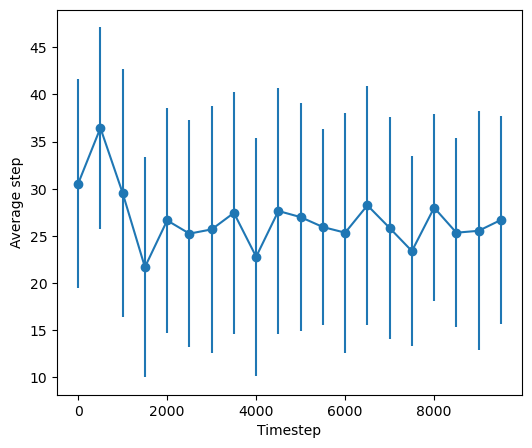

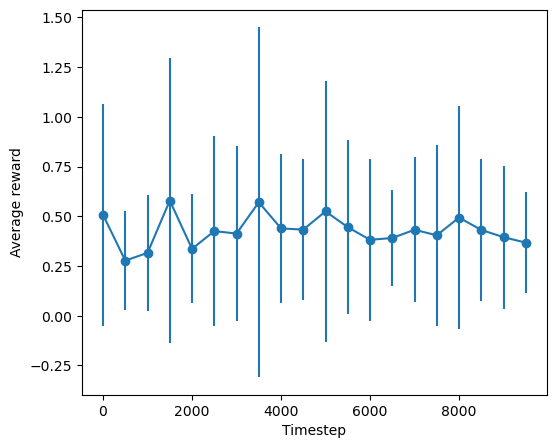

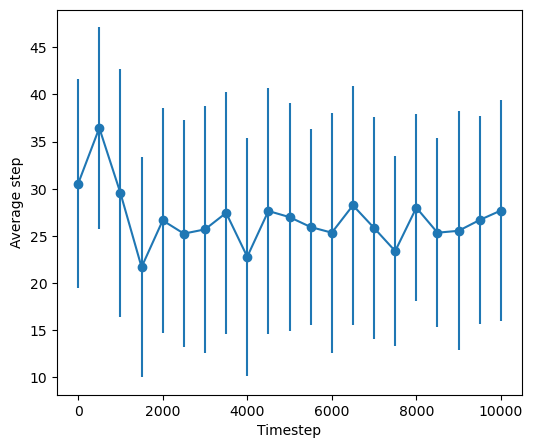

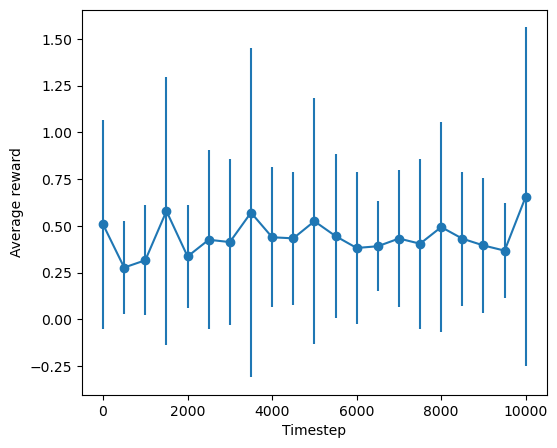

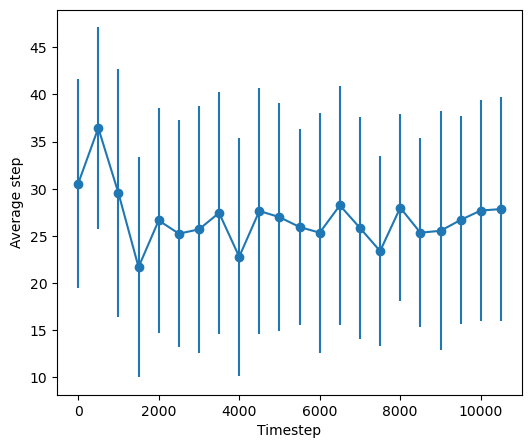

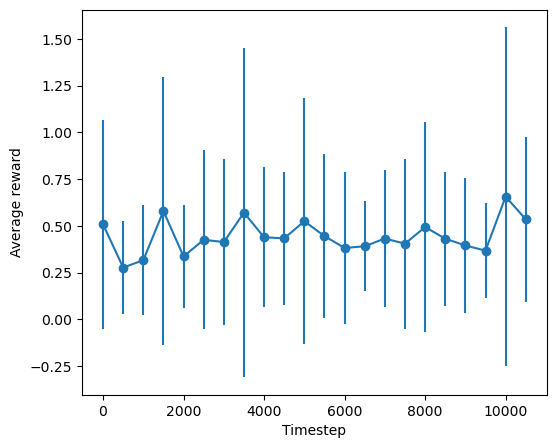

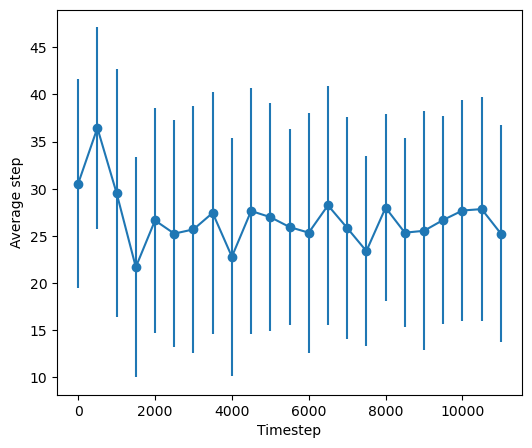

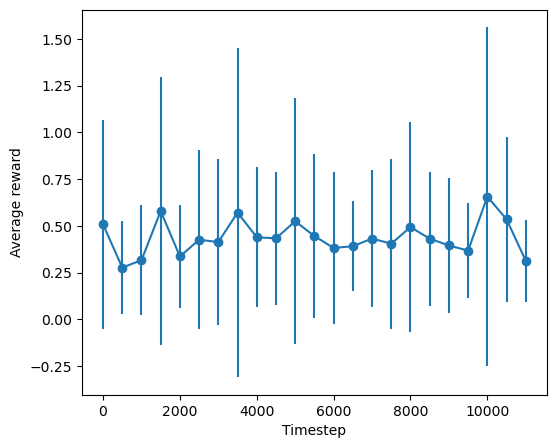

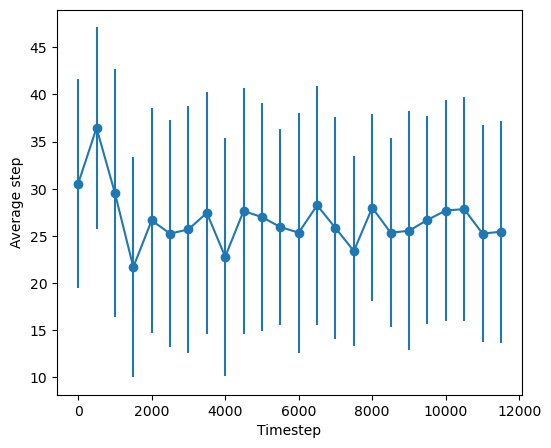

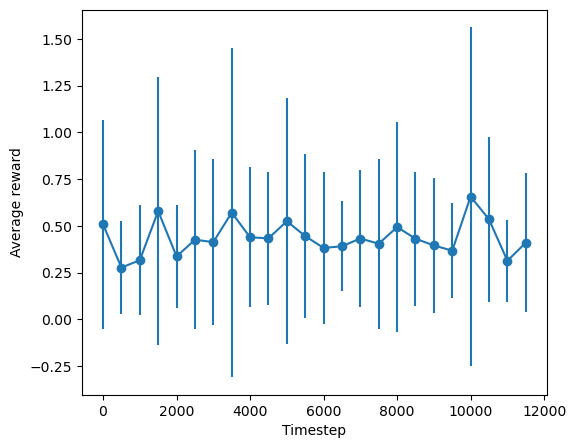

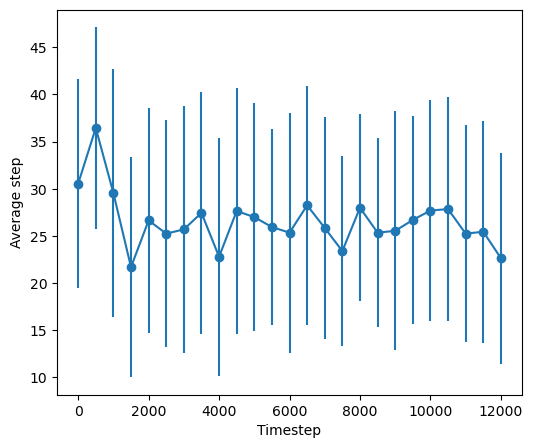

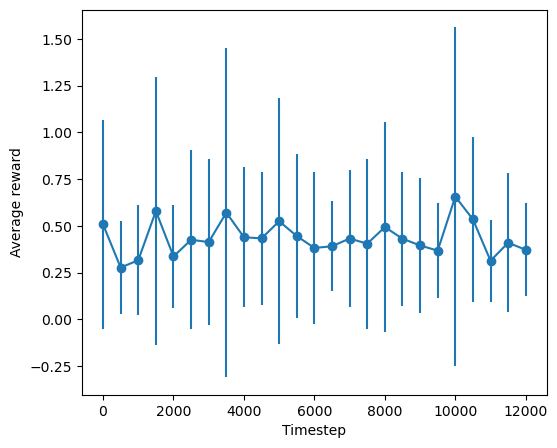

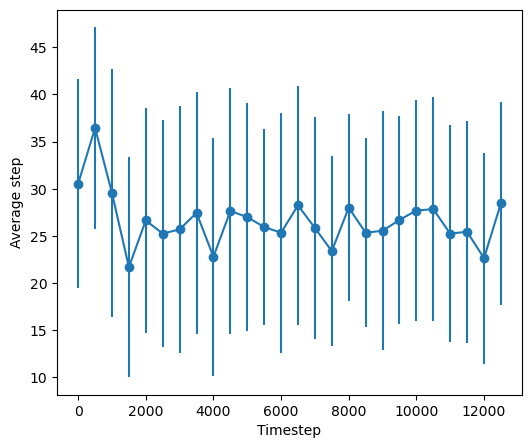

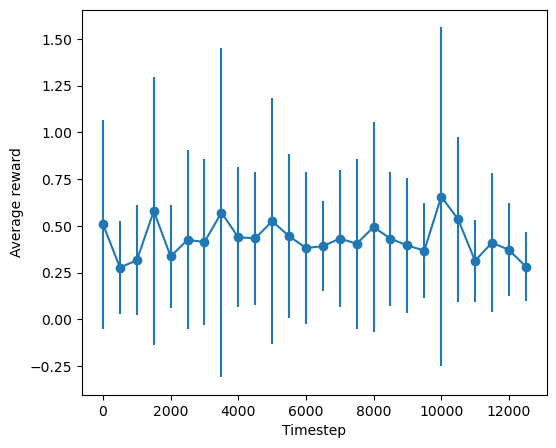

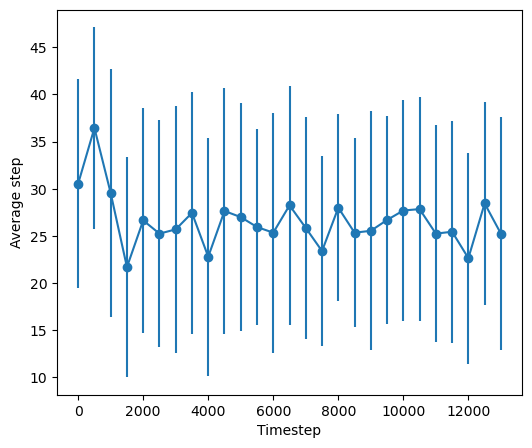

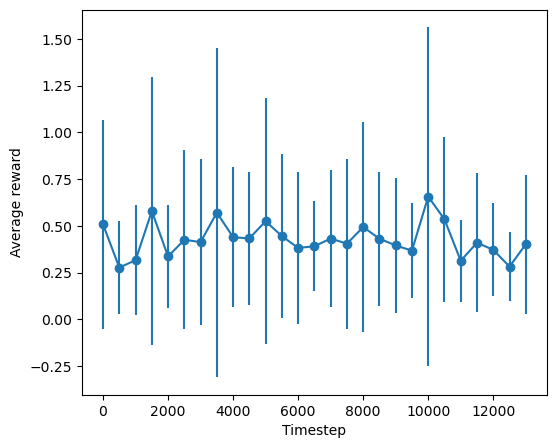

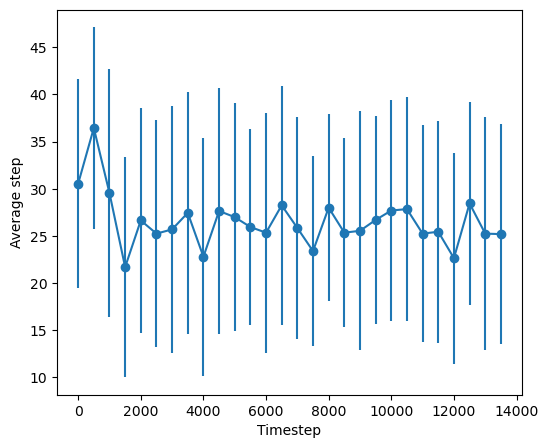

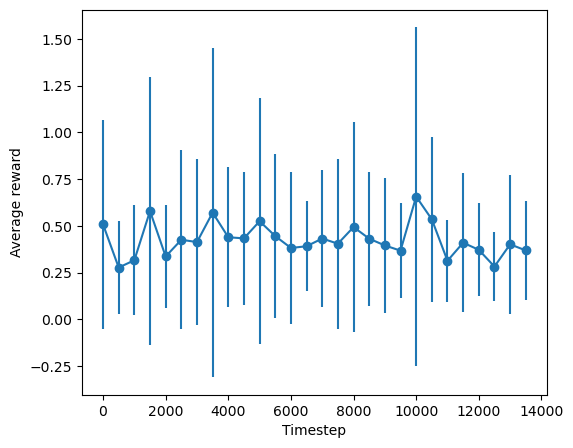

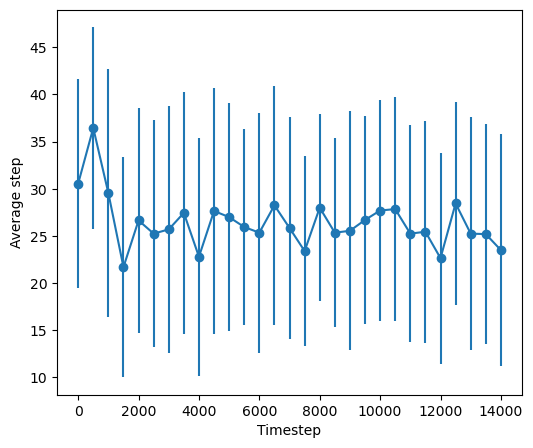

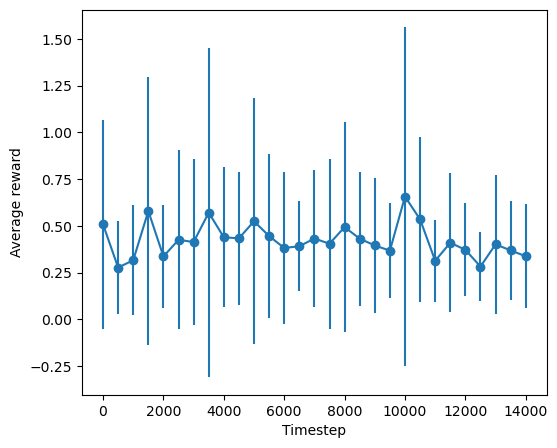

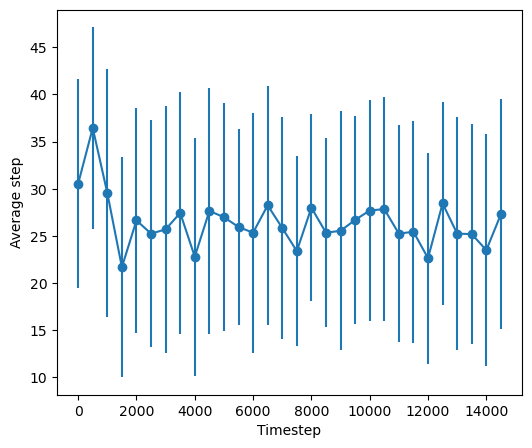

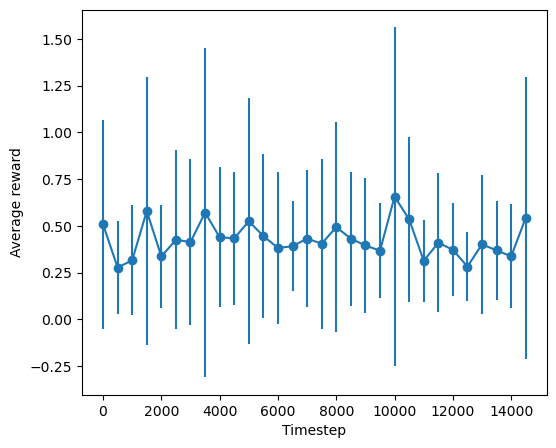

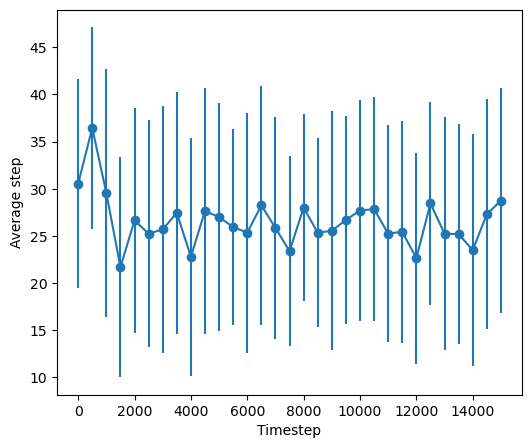

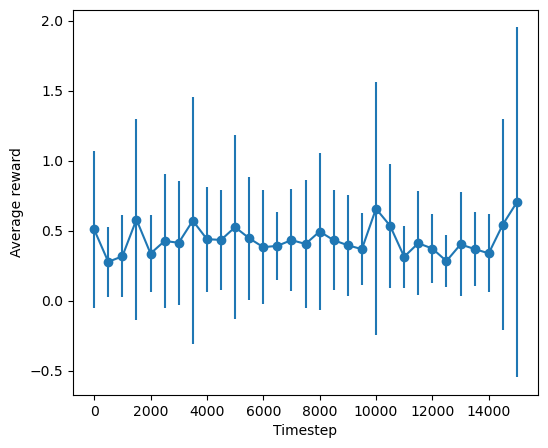

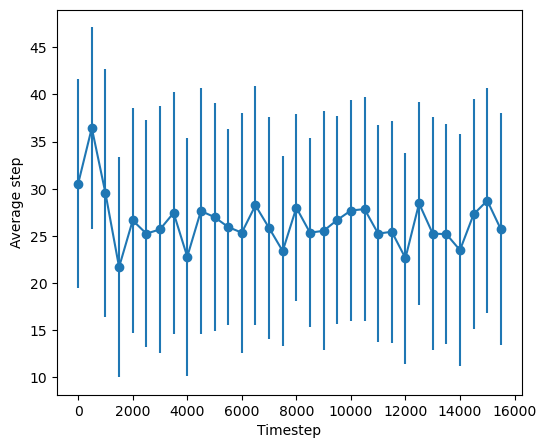

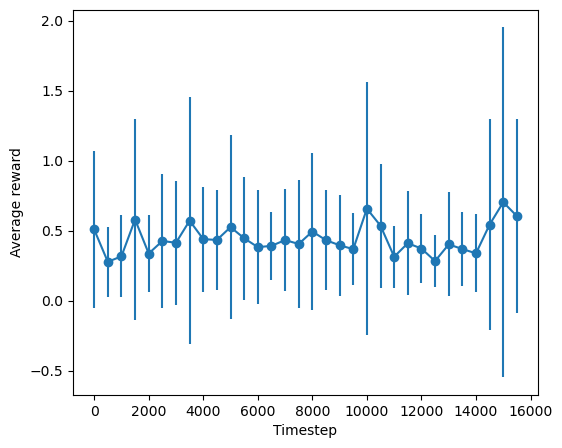

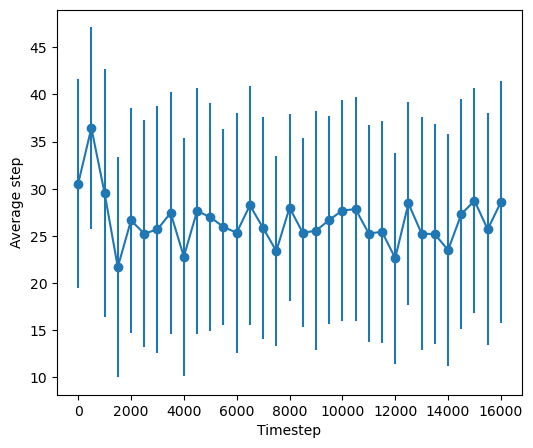

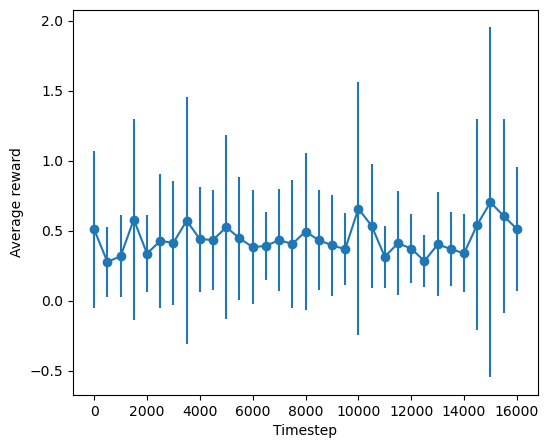

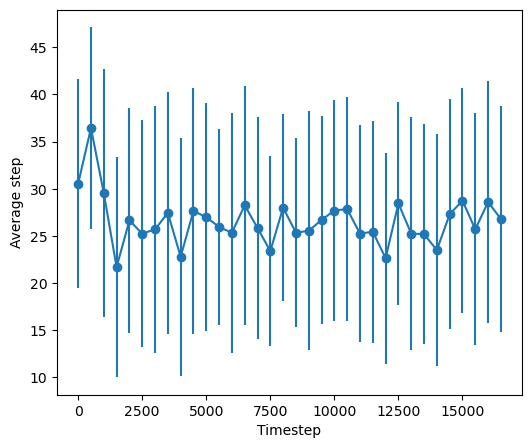

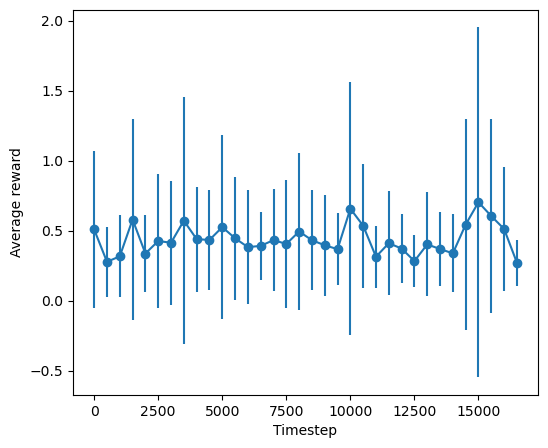

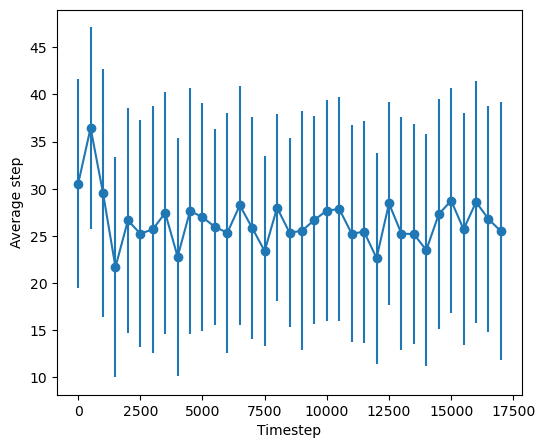

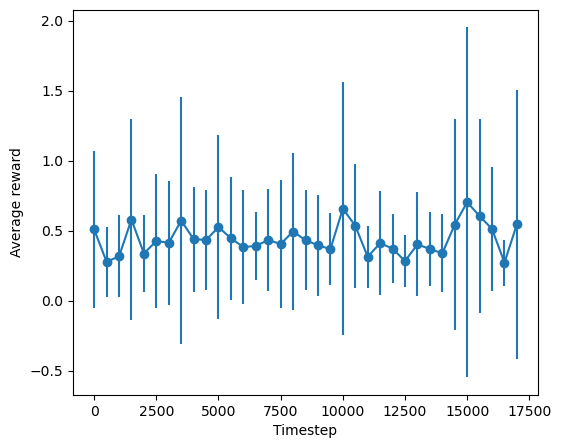

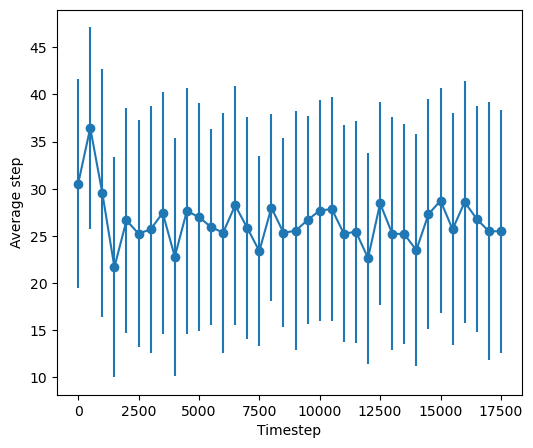

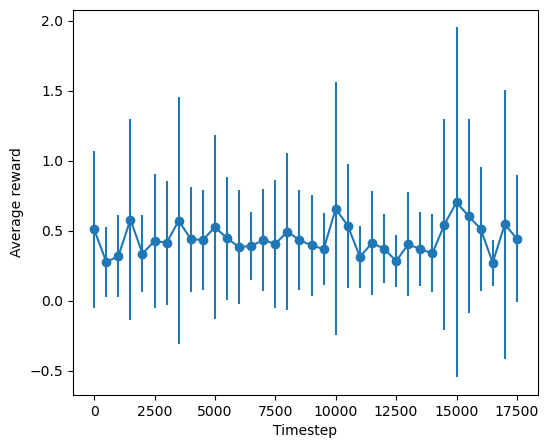

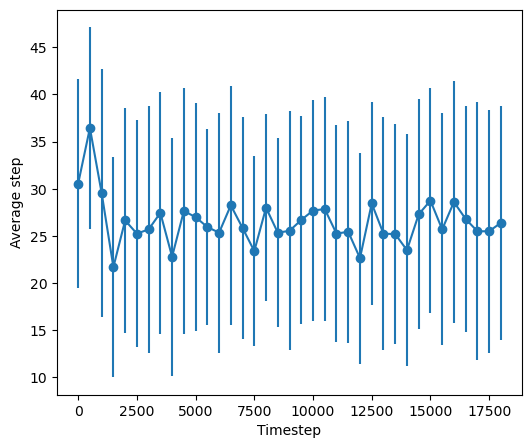

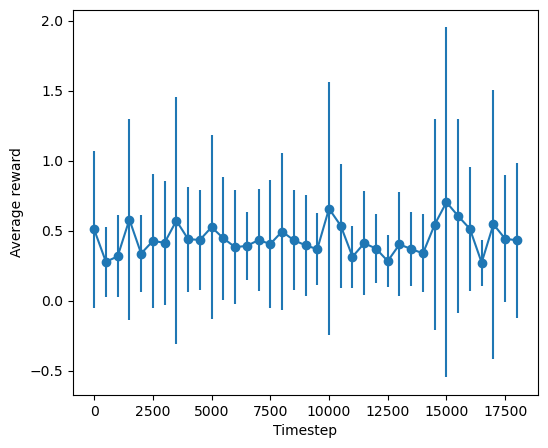

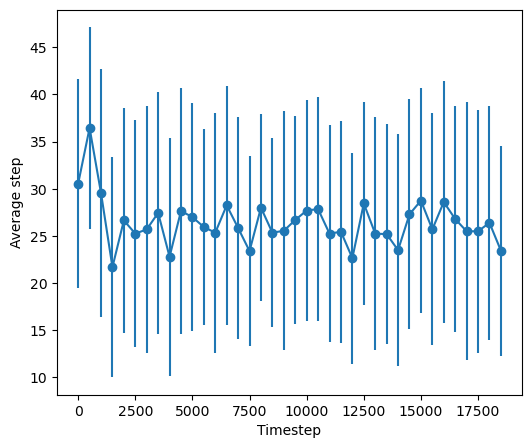

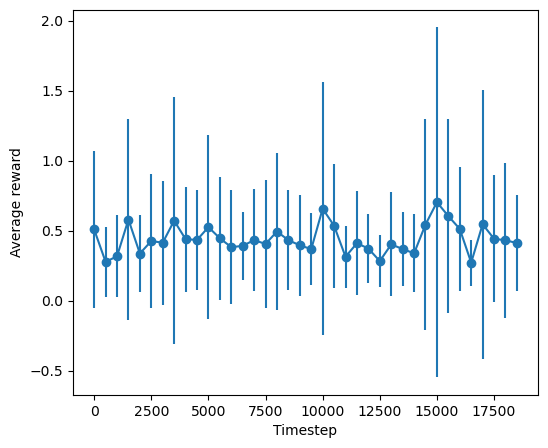

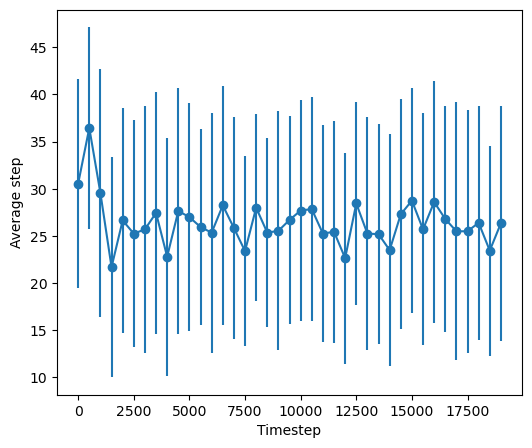

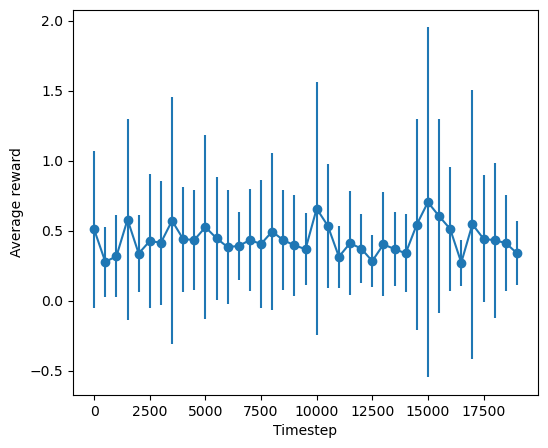

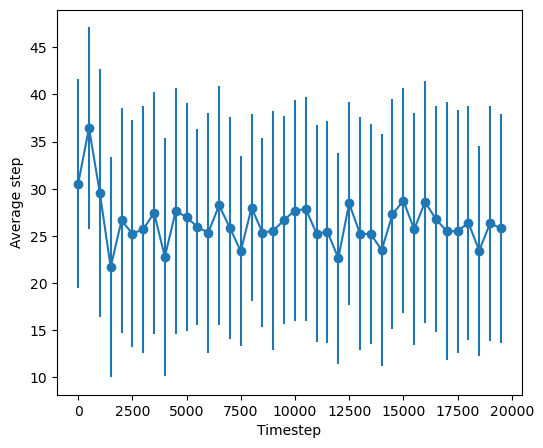

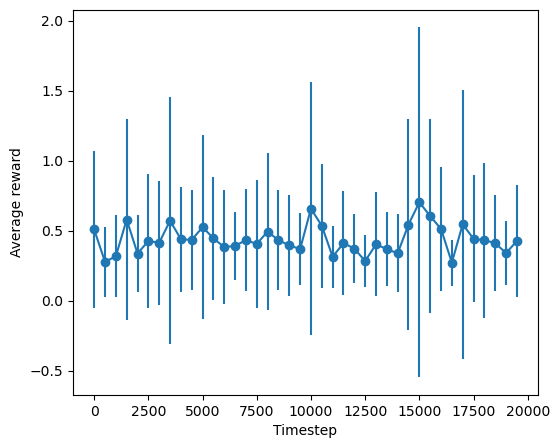

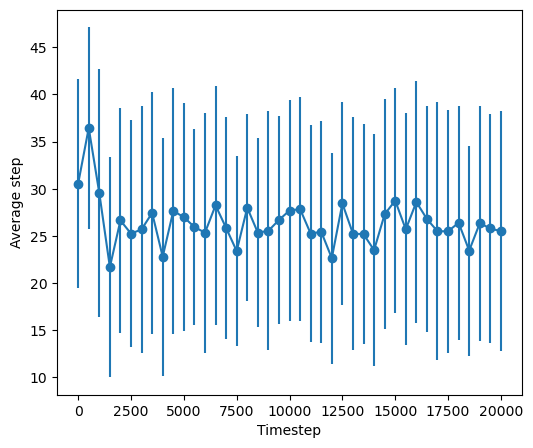

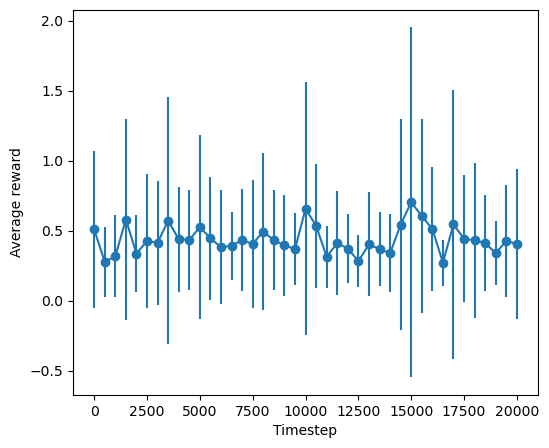

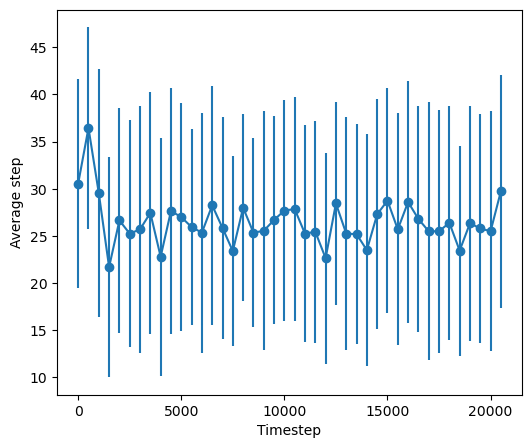

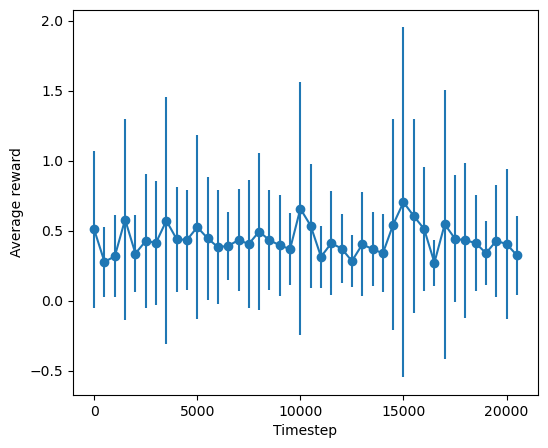

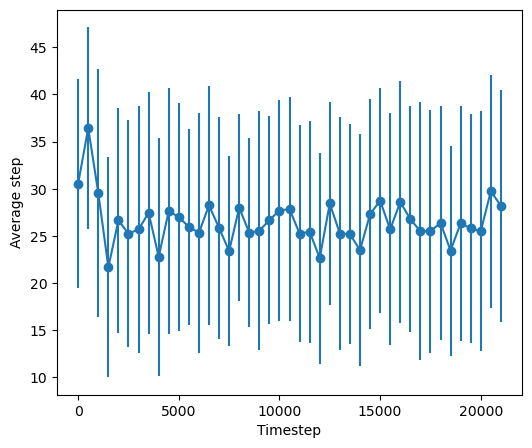

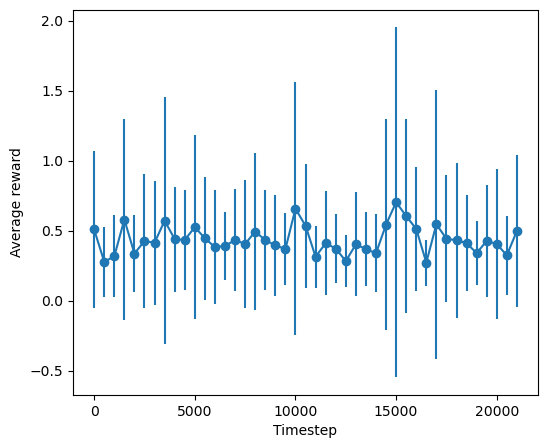

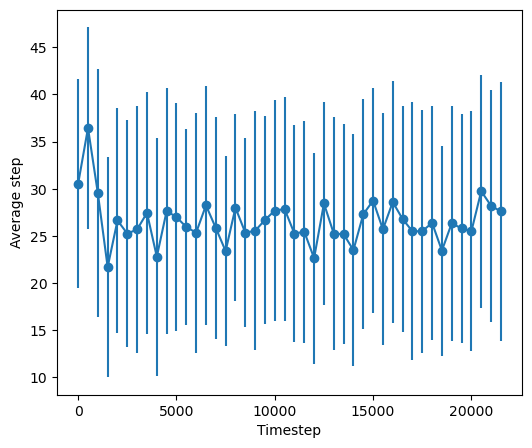

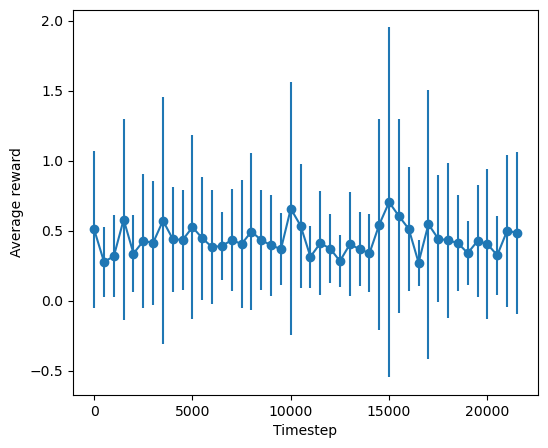

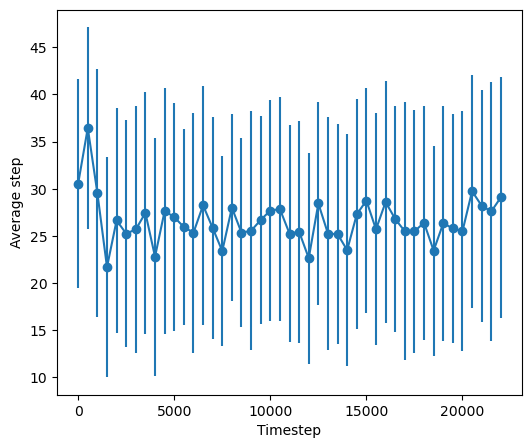

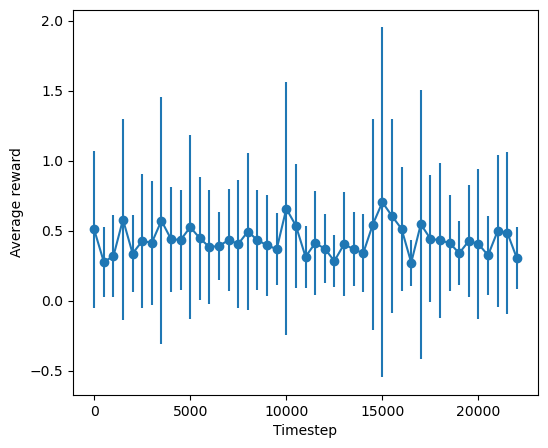

In [42]:
with tqdm(total=100) as pbar:
    while total_steps < num_iterations: 
        idx = random.sample(range(train_size), 1)[0]
        env = train_envs[idx]
        obs = observes[idx]
        num_step = num_steps[idx]

        if total_steps <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(obs)
        
    
        observation_new, reward, done, info = env.step(action)
        
        observes[idx] = deepcopy(observation_new)

        #if reward<1:
        agent.observe(obs, action, reward, done)

        # if episode > 5 and num_step % 10 == 0: 
        #     agent.update_policy()

        if total_steps>0 and total_steps % 500 == 0: 
            for _ in range(1000):
                agent.update_policy()
                
        if args.validate_steps > 0 and total_steps % args.validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward1,validate_reward2 = evaluate(test_envs, policy, debug=False, visualize=False,use_step=True)
          
        num_steps[idx] = num_step + 1
        total_steps += 1
        pbar.update(100/num_iterations)
        if done or (num_steps[idx]>60): 
            res.append(reward)
            agent.save_model(args.output)
            #env.toy_Plot(np.linspace(-1,1,50))

            observes[idx] = deepcopy(env.reset())
            num_steps[idx] =0
            episode += 1
            i=(i+1)%train_size

In [44]:
from importlib import reload 
import environment 
from sklearn.metrics import mean_squared_error

environment = reload(environment)
from environment import Environment

In [46]:
from numba import njit
import numpy as np
from warnings import filterwarnings

filterwarnings("ignore")

@njit
def sample_wiener_process_one_path(
        time_deltas: np.ndarray,
        sigma: float
) -> np.ndarray:
    """
      Generates one realization of a Wiener process (Brownian motion).

      Parameters:
      - time_deltas (np.ndarray): Array of time intervals between grid points = np.diff(time_grid).
      - sigma (float): The volatility (standard deviation) of the Wiener process.

      Returns:
      np.ndarray: An array representing the generated Wiener process path.

      Note: This function utilizes the `numba` library's JIT (Just-In-Time) compilation for improved
      performance. Ensure `numba` is installed in your environment.
    """
    normals = np.random.normal(0, sigma, len(time_deltas))
    result = np.zeros(len(time_deltas) + 1, dtype=float)
    result[1:] = np.cumsum(normals * np.sqrt(time_deltas))
    return result


@njit
def sample_wiener_process(
        number_of_simulations: int,
        time_deltas: np.ndarray,
        sigma: float
) -> np.ndarray:
    """
      Generates some realizations of a Wiener process (Brownian motion).

      Parameters:
      - number_of_simulations (int): number of paths to generate
      - time_deltas (np.ndarray): Array of time intervals between successive observations.
      - sigma (float): The volatility (standard deviation) of the Wiener process.

      Returns:
      np.ndarray: An array, each row representing the generated Wiener process trajectory.
    """
    result = np.zeros((number_of_simulations, len(time_deltas) + 1), dtype=float)
    for i in range(number_of_simulations):
        result[i] = sample_wiener_process_one_path(time_deltas, sigma)
    return result


def transform_to_monomials_degree_3(
        x: np.ndarray
) -> np.ndarray:
    """
      Transforms input features to all monomials degree <= 3

      Parameters:
      - x (np.ndarray): Input feature matrix of shape (n_samples, n_features).

      Returns:
      - transformed (np.ndarray): Array to store the transformed features, shape (n_samples, (n_features + 1) * (n_features + 2) // 2).
    """
    index = 0
    transformed = np.zeros((x.shape[0],
                            (x.shape[1] + 1) * (x.shape[1] + 2) // 2 + (x.shape[1] + 1) * (x.shape[1] + 2) * (
                                    x.shape[1] + 3) // 6
                            ), dtype=float)
    # triple-wise product
    for i in range(x.shape[1]):
        for j in range(i, x.shape[1]):
            for k in range(j, x.shape[1]):
                transformed.T[index] = x.T[i] * x.T[j] * x.T[k]
                index += 1
    # pairwise product
    for i in range(x.shape[1]):
        for j in range(i, x.shape[1]):
            transformed.T[index] = x.T[i] * x.T[j]
            index += 1
    # repeat features
    for i in range(x.shape[1]):
        transformed.T[index] = x.T[i]
    # constant feature
    transformed.T[-1] = 1.
    return transformed


def f(
        assets0: np.ndarray,
) -> float:
    """
      Calculates bermudan call option with underlying max(asset_1, asset_2, ...) and strike_t = 0, asset_i --- Wiener process

      Parameters:
      - assets0 (np.ndarray): assets at the time 0
      Returns:
      float: option price

      time_grid = np.linspace(0., 1., 31)
      sigmas = 10.
      number_of_simulations = 2 ** 13
      strike = 100.
    """
    # init
    assets0 = assets0*60+100
    number_of_simulations = 2 ** 13
    t = 10
    time_grid = np.array(list(range(365 * t + 1)))
    time_grid = time_grid[np.where(np.logical_or(time_grid % 7 == 1, time_grid % 7 == 0))] / 365
    time_deltas = np.diff(time_grid)
    number_of_steps = len(time_deltas)
    discount_rate = 0.1

    # sampling
    discount_factor = np.exp(-discount_rate * time_grid)
    strike = np.ones(number_of_steps + 1, dtype=float) * 100. * discount_factor
    number_of_assets = len(assets0)
    sigmas = np.ones_like(assets0, dtype=float) * 10.
    assets = np.zeros((number_of_assets, number_of_simulations, number_of_steps + 1), dtype=float)
    for i in range(len(sigmas)):
        assets[i] = (sample_wiener_process(number_of_simulations, time_deltas, sigmas[i]) + assets0[i]) * discount_factor

    # AMC
    option_price = np.clip(np.max(assets[:, :, -1], axis=0) - strike[-1], 0, 1e15)
    regularization_alpha = 1e-2
    weights = [None] * (number_of_steps + 1)
    for time_index in range(number_of_steps, -1, -1):
        current_payoff = np.clip(np.max(assets[:, :, time_index], axis=0) - strike[time_index], 0, 1e15)
        if time_index == 0:
            continuation_value = np.ones(number_of_simulations) * np.mean(option_price)
            in_the_money_indices = np.arange(number_of_simulations, dtype=int)
        else:
            in_the_money_indices = np.where(current_payoff > 1e-6)[0]
            if len(in_the_money_indices) < 20:
                continue
            features = assets[:, in_the_money_indices, time_index].T
            transformed = transform_to_monomials_degree_3(features)
            regularization = np.eye(transformed.shape[1], dtype=float) * regularization_alpha
            inv = np.linalg.pinv((transformed.T @ transformed + regularization), rcond=1e-4)
            weights[time_index] = inv @ transformed.T @ option_price[in_the_money_indices].reshape(-1, 1)
            continuation_value = transformed @ weights[-1]

        indicator = current_payoff[in_the_money_indices] > continuation_value.reshape(-1)
        option_price[in_the_money_indices] = \
            indicator * current_payoff[in_the_money_indices] + (~indicator) * continuation_value.reshape(-1)

    for i in range(len(sigmas)):
        assets[i] = (sample_wiener_process(number_of_simulations, time_deltas, sigmas[i]) + assets0[i]) * discount_factor

    option_price = np.clip(np.max(assets[:, :, -1], axis=0) - strike[-1], 0, 1e15)
    for time_index in range(number_of_steps, -1, -1):
        current_payoff = np.clip(np.max(assets[:, :, time_index], axis=0) - strike[time_index], 0, 1e15)
        if time_index == 0:
            continuation_value = np.ones(number_of_simulations) * np.mean(option_price)
            in_the_money_indices = np.arange(number_of_simulations, dtype=int)
        else:
            in_the_money_indices = np.where(current_payoff > 1e-6)[0]
            if len(in_the_money_indices) < 20 or weights[time_index] is None:
                continue
            features = assets[:, in_the_money_indices, time_index].T
            transformed = transform_to_monomials_degree_3(features)
            continuation_value = transformed @ weights[time_index]

        indicator = current_payoff[in_the_money_indices] > continuation_value.reshape(-1)
        option_price[in_the_money_indices] = \
            indicator * current_payoff[in_the_money_indices] + (~indicator) * continuation_value.reshape(-1)

    return np.mean(option_price)/400

np.random.seed(seed=1)
idx = np.random.randint(0,100,20)

train_points = (np.load('X_train_new.npy')[idx]-100)/60
train_answers = np.load('y_train_new.npy')[idx]/400

test_points = (np.load('X_test_new.npy')-100)/60
test_answers = np.load('y_test_new.npy')/400

In [50]:
l_bounds = [-1,]
u_bounds = [1,]
env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = f,tes=False, model = 'GP',model_param = {'d':1,'seed':1,'kernel':ConstantKernel(1.0) * Matern([1],nu=1.5),'n_restarts_optimizer':100},state_mode='predictions+last_points',N_state=20)
#Matern(np.array([1]),nu=1.5,)
state = env.reset()
agent.is_training = False

for i in range(25):
    action = agent.select_action(state)
    state, reward, done, info = env.step(action)
    model = env.mod()

In [51]:
import time
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
model = env.mod()
test_ = torch.Tensor(test_points)
start = time.time()
pr = model.predict(test_)*400
end = time.time()


time_ = end-start
mse_ = mean_squared_error(pr,test_answers.flatten()*400)
r2_ = r2_score(pr,test_answers.flatten()*400)

In [53]:
time_, mse_,r2_

(0.03751397132873535, 4.305799750362282, 0.9997027171058795)

In [190]:
time_, mse_,r2_

(0.030337095260620117, 2.868582983213736, 0.999801791680818)

In [54]:
l_bounds = [-1,]
u_bounds = [1,]
env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = f,tes=False, model = 'NN',model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1,'n_epoches':400},state_mode='predictions+last_points')

state = env.reset()
agent.is_training = False

for i in range(100):
    action = agent.select_action(state)
    state, reward, done, info = env.step(action)
    model = env.mod()
    #print(mean_squared_error(model(torch.Tensor(test_points)).detach().numpy()*400,test_answers.flatten()*400))

In [55]:
model = env.mod()
test_ = torch.Tensor(test_points)
start = time.time()
pr = model(test_).detach().numpy()
end = time.time()

time_ = end-start
mse_ = mean_squared_error(pr*400,test_answers*400)
r2_ = r2_score(pr,test_answers)

time_, mse_,r2_

(0.0004019737243652344, 0.44598233013062566, 0.999969233422921)

In [174]:
model = env.mod()
test_ = torch.Tensor(test_points)
start = time.time()
pr = model(test_).detach().numpy()
end = time.time()

time_ = end-start
mse_ = mean_squared_error(pr*400,test_answers*400)
r2_ = r2_score(pr,test_answers)

time_, mse_,r2_

(0.0018699169158935547, 2.3524111236190683, 0.9998368828527243)